Installations

In [67]:
!pip install powerlaw
!pip install python-igraph
!pip install -r requirements.txt
!pip install torch torch-geometric wandb tqdm
!pip install numpy==1.23.5 # in the new version of numpy, there is a problem with np.array

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


**Graph U-Nets Integration**
<br>
We integrate into preproc_data method the gpool operation. We will not use the coarse graph of misc-gan that generated in parse_data (R, P, W and c values). We used gpool operation instead.

In the fist approach, in the test method of cycle-gan class, after generating the new coarse graph, we will apply gunpool operation on it. The generate_network iterate on each layer and it executes the test method of cycle-gan.

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch_geometric.utils import remove_self_loops
import numpy as np

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")  # Set device to GPU
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")

GPU is available!


In [70]:
class GNet(nn.Module):
    def __init__(self, in_dim, n_classes, args):
        super(GNet, self).__init__()
        self.n_act = getattr(nn, args.act_n)()
        self.c_act = getattr(nn, args.act_c)()
        self.s_gcn = GCN(in_dim, args.l_dim, self.n_act, args.drop_n)
        self.g_unet = GraphUnet(
            args.ks, args.l_dim, args.l_dim, args.l_dim, self.n_act,
            args.drop_n)
        self.out_l_1 = nn.Linear(3*args.l_dim*(args.l_num+1), args.h_dim)
        self.out_l_2 = nn.Linear(args.h_dim, n_classes)
        self.out_drop = nn.Dropout(p=args.drop_c)
        Initializer.weights_init(self)

    def forward(self, gs, hs, labels):
        hs = self.embed(gs, hs)
        logits = self.classify(hs)
        return self.metric(logits, labels)

    def embed(self, gs, hs):
        o_hs = []
        for g, h in zip(gs, hs):
            h = self.embed_one(g, h)
            o_hs.append(h)
        hs = torch.stack(o_hs, 0)
        return hs

    def embed_one(self, g, h):
        g = norm_g(g)
        h = self.s_gcn(g, h)
        hs = self.g_unet(g, h)
        h = self.readout(hs)
        return h

    def readout(self, hs):
        h_max = [torch.max(h, 0)[0] for h in hs]
        h_sum = [torch.sum(h, 0) for h in hs]
        h_mean = [torch.mean(h, 0) for h in hs]
        h = torch.cat(h_max + h_sum + h_mean)
        return h

    def classify(self, h):
        h = self.out_drop(h)
        h = self.out_l_1(h)
        h = self.c_act(h)
        h = self.out_drop(h)
        h = self.out_l_2(h)
        return F.log_softmax(h, dim=1)

    def metric(self, logits, labels):
        loss = F.nll_loss(logits, labels)
        _, preds = torch.max(logits, 1)
        acc = torch.mean((preds == labels).float())
        return loss, acc


In [71]:
class GraphUnet(nn.Module):

    def __init__(self, ks, in_dim, out_dim, dim, act, drop_p):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.bottom_gcn = GCN(dim, dim, act, drop_p)
        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim, act, drop_p))
            self.up_gcns.append(GCN(dim, dim, act, drop_p))
            self.pools.append(Pool(ks[i], dim, drop_p))
            self.unpools.append(Unpool(dim, dim, drop_p))

    def forward(self, g, h):
        adj_ms = []
        indices_list = []
        down_outs = []
        hs = []
        org_h = h
        for i in range(self.l_n):
            h = self.down_gcns[i](g, h)
            adj_ms.append(g)
            down_outs.append(h)
            g, h, idx = self.pools[i](g, h)
            indices_list.append(idx)
        h = self.bottom_gcn(g, h)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            g, idx = adj_ms[up_idx], indices_list[up_idx]
            g, h = self.unpools[i](g, h, down_outs[up_idx], idx)
            h = self.up_gcns[i](g, h)
            h = h.add(down_outs[up_idx])
            hs.append(h)
        h = h.add(org_h)
        hs.append(h)
        return hs


class GCN(nn.Module):

    def __init__(self, in_dim, out_dim, act, p):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.act = act
        self.drop = nn.Dropout(p=p) if p > 0.0 else nn.Identity()

    def forward(self, g, h):
        h = self.drop(h)
        h = torch.matmul(g, h)
        h = self.proj(h)
        h = self.act(h)
        return h

class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(nn.Module):
    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, g, h, pre_h, idx):
        new_h = h.new_zeros([g.shape[0], h.shape[1]])
        # Subset h to match the size of idx
        h_subset = h[:len(idx)]
        # Debug: Print shapes before assignment
        print(f"Shape of new_h before assignment: {new_h.shape}")
        print(f"Shape of h_subset: {h_subset.shape}")
        print(f"Shape of idx: {idx.shape}")
        new_h[idx] = h_subset
        return g, new_h
    '''def forward(self, g, h, pre_h, idx):
        new_h = h.new_zeros([g.shape[0], h.shape[1]])
        new_h[idx] = h
        return g, new_h'''


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes)))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx


def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g

In [72]:
class Initializer(object):

    @classmethod
    def _glorot_uniform(cls, w):
        if len(w.size()) == 2:
            fan_in, fan_out = w.size()
        elif len(w.size()) == 3:
            fan_in = w.size()[1] * w.size()[2]
            fan_out = w.size()[0] * w.size()[2]
        else:
            fan_in = np.prod(w.size())
            fan_out = np.prod(w.size())
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        w.uniform_(-limit, limit)

    @classmethod
    def _param_init(cls, m):
        if isinstance(m, nn.parameter.Parameter):
            cls._glorot_uniform(m.data)
        elif isinstance(m, nn.Linear):
            m.bias.data.zero_()
            cls._glorot_uniform(m.weight.data)

    @classmethod
    def weights_init(cls, m):
        for p in m.modules():
            if isinstance(p, nn.ParameterList):
                for pp in p:
                    cls._param_init(pp)
            else:
                cls._param_init(p)

        for name, p in m.named_parameters():
            if '.' not in name:
                cls._param_init(p)

In [73]:
class GNetArgs:
    seed = 1
    data = 'PROTEINS'
    fold = 1
    num_epochs = 100
    batch = 32
    lr = 0.001
    deg_as_tag = 0
    l_num = 3
    h_dim = 128
    l_dim = 48
    drop_n = 0.5
    drop_c = 0.5
    act_n = 'ELU'
    act_c = 'ELU'
    ks = [0.9, 0.8, 0.7]
    acc_file = 're'
    in_dim = 3  # Set to 3 because of the size of Graph Data of PROTEINS
    save_model = '/content/drive/MyDrive/Misc-Gan_Project/graph_unet_model.pth'

gnet_args = GNetArgs()
net = GNet(in_dim=gnet_args.in_dim, n_classes=2, args=gnet_args)

def load_model_parameters(model, model_path):
    pretrained_dict = torch.load(model_path)
    #pretrained_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model_path = gnet_args.save_model
load_model_parameters(net, model_path)
net.eval()

# for g-unets integration
global_params = {
    "down_outs_list": [],
    "indices_list_list": []
}

Imports

In [74]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import argparse
import networkx as nx
import scipy.sparse as sp
import scipy.io as sio
import sys
import os
from collections import namedtuple
import math
import time
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from scipy.sparse.csgraph import connected_components
from __future__ import division
from __future__ import print_function
import copy
import powerlaw
import collections
import igraph
# grapharm.py
from tqdm import tqdm
import torch
import wandb
import torch.nn as nn
import logging
import tf_slim as slim # import tensorflow.contrib.slim as slim also legacy and goolge colab removed it
from tensorflow.python.framework import ops

print(np.__version__)

1.25.2


In [75]:
class Args:
  def __init__(self, version=-1):
    self.demo = False
    self.dataset_A = f'cora_{version}.mat' if version > -1 else 'cora.mat'  # path of the data set
    self.checkpoint = f'/content/Misc-Gan_Project/checkpoint_training_cora_{version}' if version > -1 else '/content/Misc-Gan_Project/checkpoint_training_cora'  # path of the checkpoint
    self.filename = f'cora_output_network_{version}' if version > -1 else 'cora_output_network'  # the filename of output network
    self.output_dir = f'/content/Misc-Gan_Project/output_dir_cora_{version}' if version > -1 else '/content/Misc-Gan_Project/output_dir_cora'  # results are saved here
    self.epoch = 100  # number of epoch
    self.layer = 3  # number of layers
    self.clusters = 2  # number of clusters (2 or 3)
    self.use_resnet = True  # generation network using reidule block
    self.use_lsgan = True  # gan loss defined in lsgan
    self.which_direction = 'BtoA'  # AtoB or BtoA
    self.which_stage = 'training'  # training stage or testing stage
    self.starting_layer = 1  # the starting layer
    self.shuffle = True  # Shuffle the graph
    self.gpu = True  # Use gpu to train the model or not
    self.kernel_number = 32  # Shuffle the graph
    self.iter = 5  # Iterations of residule_block function for generator to train graph

args = Args()

Gae Module

initializations.py

In [76]:
def weight_variable_glorot(input_dim, output_dim, name=""):
    """Create a weight variable with Glorot & Bengio (AISTATS 2010)
    initialization.
    """
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.compat.v1.random_uniform([input_dim, output_dim], minval=-init_range,
                                maxval=init_range, dtype=tf.compat.v1.float32)
    return tf.compat.v1.Variable(initial, name=name)


input_data.py

In [77]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

In [78]:
def load_data(dataset):
    # load the data: x, tx, allx, graph
    names = ['x', 'tx', 'allx', 'graph']
    objects = []
    for i in range(len(names)):
        objects.append(pkl.load(open("/content/drive/MyDrive/Misc-Gan_Project/data/ind.{}.{}".format(dataset, names[i]))))
    x, tx, allx, graph = tuple(objects)
    test_idx_reorder = parse_index_file("/content/drive/MyDrive/Misc-Gan_Project/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    return adj, features

In [79]:
def load_network_data(filename):
    network_A = sio.loadmat('/content/drive/MyDrive/Misc-Gan_Project/data/{}'.format(filename))
    A = network_A['A']
    R = network_A['R'].transpose()
    edges = network_A['edges']
    return A, R, edges

layers.py

In [80]:
flags = tf.compat.v1.flags # tf.app.flags is legacy code of tf version 1
FLAGS = flags.FLAGS

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}

In [81]:
def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs
    """
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]

In [82]:
def dropout_sparse(x, keep_prob, num_nonzero_elems):
    """Dropout for sparse tensors. Currently fails for very large sparse tensors (>1M elements)
    """
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.compat.v1.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.compat.v1.floor(random_tensor), dtype=tf.compat.v1.bool)
    pre_out = tf.compat.v1.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)

In [83]:
class Layer(object):
    """Base layer class. Defines basic API for all layer objects.

    # Properties
        name: String, defines the variable scope of the layer.

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
    """
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.issparse = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.compat.v1.name_scope(self.name):
            outputs = self._call(inputs)
            return outputs

In [84]:
class GraphConvolution1(Layer):
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, dropout=0., act=tf.compat.v1.nn.relu, **kwargs):
        super(GraphConvolution1, self).__init__(**kwargs)
        with tf.compat.v1.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act

    def _call(self, inputs):
        x = inputs
        x = tf.compat.v1.nn.dropout(x, 1-self.dropout)
        x = tf.compat.v1.matmul(x, self.vars['weights'])
        x = tf.compat.v1.sparse_tensor_dense_matmul(self.adj, x)
        outputs = self.act(x)
        return outputs

In [85]:

class GraphConvolutionSparse(Layer):
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, dropout=0., act=tf.compat.v1.nn.relu, **kwargs):
        super(GraphConvolutionSparse, self).__init__(**kwargs)
        with tf.compat.v1.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def _call(self, inputs):
        x = inputs
        x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
        x = tf.compat.v1.sparse_tensor_dense_matmul(x, self.vars['weights'])
        x = tf.compat.v1.sparse_tensor_dense_matmul(self.adj, x)
        outputs = self.act(x)
        return outputs


In [86]:
class InnerProductDecoder(Layer):
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, dropout=0., act=tf.compat.v1.nn.sigmoid, **kwargs):
        super(InnerProductDecoder, self).__init__(**kwargs)
        self.dropout = dropout
        self.act = act

    def _call(self, inputs):
        inputs = tf.compat.v1.nn.dropout(inputs, 1-self.dropout)
        x = tf.compat.v1.transpose(inputs)
        x = tf.compat.v1.matmul(inputs, x)
        x = tf.compat.v1.reshape(x, [-1])
        outputs = self.act(x)
        return outputs

model.py

In [87]:
flags = tf.compat.v1.flags # tf.app.flags is legacy code of tf version 1
FLAGS = flags.FLAGS

class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg

        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.compat.v1.variable_scope(self.name):
            self._build()
        variables = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

    def fit(self):
        pass

    def predict(self):
        pass

In [88]:
class GCNModelAE(Model):
    def __init__(self, placeholders, num_features, features_nonzero, **kwargs):
        super(GCNModelAE, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.build()

    def _build(self):
        self.hidden1 = GraphConvolutionSparse(input_dim=self.input_dim,
                                              output_dim=FLAGS.hidden1,
                                              adj=self.adj,
                                              features_nonzero=self.features_nonzero,
                                              act=tf.compat.v1.nn.relu,
                                              dropout=self.dropout,
                                              logging=self.logging)(self.inputs)

        self.embeddings = GraphConvolution1(input_dim=FLAGS.hidden1,
                                           output_dim=FLAGS.hidden2,
                                           adj=self.adj,
                                           act=lambda x: x,
                                           dropout=self.dropout,
                                           logging=self.logging)(self.hidden1)

        self.z_mean = self.embeddings

        self.reconstructions = InnerProductDecoder(input_dim=FLAGS.hidden2,
                                      act=lambda x: x,
                                      logging=self.logging)(self.embeddings)

In [89]:
class GCNModelVAE(Model):
    def __init__(self, placeholders, num_features, num_nodes, features_nonzero, **kwargs):
        super(GCNModelVAE, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.n_samples = num_nodes
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.build()

    def _build(self):
        self.hidden1 = GraphConvolutionSparse(input_dim=self.input_dim,
                                              output_dim=FLAGS.hidden1,
                                              adj=self.adj,
                                              features_nonzero=self.features_nonzero,
                                              act=tf.compat.v1.nn.relu,
                                              dropout=self.dropout,
                                              logging=self.logging)(self.inputs)

        self.z_mean = GraphConvolution1(input_dim=FLAGS.hidden1,
                                       output_dim=FLAGS.hidden2,
                                       adj=self.adj,
                                       act=lambda x: x,
                                       dropout=self.dropout,
                                       logging=self.logging)(self.hidden1)

        self.z_log_std = GraphConvolution1(input_dim=FLAGS.hidden1,
                                          output_dim=FLAGS.hidden2,
                                          adj=self.adj,
                                          act=lambda x: x,
                                          dropout=self.dropout,
                                          logging=self.logging)(self.hidden1)

        self.z = self.z_mean + tf.compat.v1.random_normal([self.n_samples, FLAGS.hidden2]) * tf.compat.v1.exp(self.z_log_std)

        self.reconstructions = InnerProductDecoder(input_dim=FLAGS.hidden2,
                                      act=lambda x: x,
                                      logging=self.logging)(self.z)

optimizer.py

In [90]:
flags = tf.compat.v1.flags # tf.app.flags is legacy code of tf version 1
FLAGS = flags.FLAGS

class OptimizerAE(object):
    def __init__(self, preds, labels, pos_weight, norm):
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.compat.v1.reduce_mean(tf.compat.v1.nn.weighted_cross_entropy_with_logits(logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

        self.correct_prediction = tf.compat.v1.equal(tf.compat.v1.cast(tf.compat.v1.greater_equal(tf.compat.v1.sigmoid(preds_sub), 0.5), tf.compat.v1.int32),
                                           tf.compat.v1.cast(labels_sub, tf.compat.v1.int32))
        self.accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(self.correct_prediction, tf.compat.v1.float32))


In [91]:
class OptimizerVAE(object):
    def __init__(self, preds, labels, model, num_nodes, pos_weight, norm):
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.compat.v1.reduce_mean(tf.compat.v1.nn.weighted_cross_entropy_with_logits(logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        # Latent loss
        self.log_lik = self.cost
        self.kl = (0.5 / num_nodes) * tf.compat.v1.reduce_mean(tf.compat.v1.reduce_sum(1 + 2 * model.z_log_std - tf.compat.v1.square(model.z_mean) -
                                                                   tf.compat.v1.square(tf.compat.v1.exp(model.z_log_std)), 1))
        self.cost -= self.kl

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

        self.correct_prediction = tf.compat.v1.equal(tf.compat.v1.cast(tf.compat.v1.greater_equal(tf.compat.v1.sigmoid(preds_sub), 0.5), tf.compat.v1.int32),
                                           tf.compat.v1.cast(labels_sub, tf.compat.v1.int32))
        self.accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(self.correct_prediction, tf.compat.v1.float32))

preprocessing.py

In [92]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [93]:
def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)

In [94]:
def construct_feed_dict(adj_normalized, adj, features, placeholders):
    # construct feed dictionary
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict

In [95]:
def mask_test_edges(adj):
    # Function to build test set with 10% positive links
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
    # TODO: Clean up.

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    # assert np.diag(adj.todense()).sum() == 0

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    # edges_all = sparse_to_tuple(adj)[0]
    # num_test = int(np.floor(edges.shape[0] / 10.))
    # num_val = int(np.floor(edges.shape[0] / 20.))

    # all_edge_idx = range(edges.shape[0])
    # np.random.shuffle(all_edge_idx)
    # val_edge_idx = all_edge_idx[:num_val]
    # test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    # test_edges = edges[test_edge_idx]
    # val_edges = edges[val_edge_idx]
    # train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
    train_edges = edges

    # def ismember(a, b, tol=5):
    #     rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
    #     return np.any(rows_close)
    #
    # test_edges_false = []
    # while len(test_edges_false) < len(test_edges):
    #     idx_i = np.random.randint(0, adj.shape[0])
    #     idx_j = np.random.randint(0, adj.shape[0])
    #     if idx_i == idx_j:
    #         continue
    #     if ismember([idx_i, idx_j], edges_all):
    #         continue
    #     if test_edges_false:
    #         if ismember([idx_j, idx_i], np.array(test_edges_false)):
    #             continue
    #         if ismember([idx_i, idx_j], np.array(test_edges_false)):
    #             continue
    #     test_edges_false.append([idx_i, idx_j])

    # val_edges_false = []
    # while len(val_edges_false) < len(val_edges):
    #     idx_i = np.random.randint(0, adj.shape[0])
    #     idx_j = np.random.randint(0, adj.shape[0])
    #     if idx_i == idx_j:
    #         continue
    #     if ismember([idx_i, idx_j], train_edges):
    #         continue
    #     if ismember([idx_j, idx_i], train_edges):
    #         continue
    #     if ismember([idx_i, idx_j], val_edges):
    #         continue
    #     if ismember([idx_j, idx_i], val_edges):
    #         continue
    #     if val_edges_false:
    #         if ismember([idx_j, idx_i], np.array(val_edges_false)):
    #             continue
    #         if ismember([idx_i, idx_j], np.array(val_edges_false)):
    #             continue
    #     val_edges_false.append([idx_i, idx_j])
    #
    # assert ~ismember(test_edges_false, edges_all)
    # assert ~ismember(val_edges_false, edges_all)
    # assert ~ismember(val_edges, train_edges)
    # assert ~ismember(test_edges, train_edges)
    # assert ~ismember(val_edges, test_edges)

    data = np.ones(train_edges.shape[0])

    # Re-build adj matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges #, val_edges, val_edges_false, test_edges, test_edges_false

utils_network.py

In [96]:
# new added functions for GraphARM
class ImagePool(object):
    def __init__(self, maxsize=50):
        self.maxsize = maxsize
        self.num_img = 0
        self.images = []

    def __call__(self, image):
        if self.maxsize <= 0:
            return image
        if self.num_img < self.maxsize:
            self.images.append(image)
            self.num_img += 1
            return image
        if np.random.rand() > 0.5:
            idx = int(np.random.rand()*self.maxsize)
            tmp1 = copy.copy(self.images[idx])[0]
            self.images[idx][0] = image[0]
            idx = int(np.random.rand()*self.maxsize)
            tmp2 = copy.copy(self.images[idx])[1]
            self.images[idx][1] = image[1]
            return [tmp1, tmp2]
        else:
            return image

In [97]:
# --- loading dataset --- #
def load_mat_file():
    network_A = sio.loadmat('/content/drive/MyDrive/Misc-Gan_Project/data/{}'.format(args.dataset_A))
    A = network_A['A']
    P = network_A['P'].transpose()
    W = network_A['W']
    R = network_A['R'].transpose()
    edges = network_A['edges']
    cluster_info = network_A['IDX'].flatten()
    c = network_A['c'][0]
    clusters_info = []
    prev = 1
    for j in range(len(c)):
        idx = np.zeros(R[j, 0].shape[1], dtype=np.int16)
        for i in range(len(idx)):
            if i+1 not in c[j][0]:
                idx[i] = prev
            else:
                idx[i] = cluster_info[i]
                prev = idx[i]
        clusters_info.append(np.array(idx))

    # Find the maximum length among the arrays in clusters_info
    max_len = max([len(arr) for arr in clusters_info])

    # Pad the arrays in clusters_info to have the same length
    padded_clusters_info = []
    for arr in clusters_info:
        padded_arr = np.pad(arr, (0, max_len - len(arr)), 'constant')
        padded_clusters_info.append(padded_arr)

    clusters_info = np.array(padded_clusters_info)
    indices = [[] for _ in range(len(clusters_info))]
    min_value = np.min(clusters_info[0])
    for j in range(len(clusters_info)):
        index = [[] for _ in range(args.clusters)]
        for c in range(args.clusters):
            for i in range(len(clusters_info[j])):
                if clusters_info[j][i] == c + min_value:
                    index[c].append(i)
        # Convert sublists to NumPy arrays and pad them to equal length
        index = [np.array(sublist) for sublist in index]
        max_sublist_len = max(len(sublist) for sublist in index)
        index = [np.pad(sublist, (0, max_sublist_len - len(sublist)), 'constant') for sublist in index]
        indices[j] = np.array(index)  # Now, 'index' contains arrays of equal length

    # Reshape indices to a 3D array, handling varying lengths
    max_sublist_len = max(indices[i].shape[1] for i in range(len(indices)))
    indices_reshaped = np.empty((len(indices), indices[0].shape[0], max_sublist_len))
    for i in range(len(indices)):
        indices_reshaped[i, :, :indices[i].shape[1]] = indices[i] # Slice indices_reshaped to accommodate varying lengths

    return A, P, W, R, indices_reshaped, edges # Return the reshaped indices

In [98]:
#Shahar Vachiler
def gpool_operation(A_copy, net, gnet_args):
    A_copy_tensor = torch.tensor(A_copy, dtype=torch.float32)
    feature_tensor = torch.randn((A_copy_tensor.shape[0], gnet_args.l_dim), dtype=torch.float32)

    down_outs = []
    indices_list = []

    with torch.no_grad():
        for j in range(net.g_unet.l_n):
            feature_tensor = net.g_unet.down_gcns[j](A_copy_tensor, feature_tensor)
            down_outs.append(feature_tensor.clone())
            A_copy_tensor, feature_tensor, coarsening_indices = net.g_unet.pools[j](A_copy_tensor, feature_tensor)
            indices_list.append(coarsening_indices)

        coarsened_graph, coarsened_features = A_copy_tensor, feature_tensor

    return coarsened_graph, coarsened_features, down_outs, indices_list

def preproc_data(sess, net, gnet_args):
    init_op = tf.compat.v1.global_variables_initializer()
    sess.run(init_op)
    A, P, W, R, indices, edges = load_mat_file()

    # Preserve the original graph
    A_copy = np.array(A.todense(), copy=True) if hasattr(A, 'todense') else np.array(A, copy=True)
    data_A = dict()
    data_B = dict()
    A_layer = []

    global_params["down_outs_list"].clear()
    global_params["indices_list_list"].clear()

    for i in range(1, args.layer + 1):
        # Store the intermediate coarse graph before G-Pool operation
        A_layer.append(A_copy.copy())

        # Perform G-Pool operation
        coarsened_graph, coarsened_features, down_outs, indices_list = gpool_operation(A_copy, net, gnet_args)
        A_copy = coarsened_graph.detach().numpy()

        #Ensure shuffle_list indices are within the valid range and filter out invalid entries
        shuffle_list = np.array(indices[i-1][0] + indices[i-1][1])
        shuffle_list = shuffle_list[~np.isnan(shuffle_list)]  # Remove NaN values
        shuffle_list = shuffle_list[shuffle_list >= 0]  # Remove negative values
        shuffle_list = shuffle_list[shuffle_list < A_copy.shape[0]]  # Ensure indices are within bounds
        shuffle_list = shuffle_list.astype(int)  # Convert to integers
        if args.shuffle:
            data_A['l{}_{}'.format(i, 1)] = zero_padding(A_copy[shuffle_list, :][:, shuffle_list])
            data_B['l{}_{}'.format(i, 1)] = zero_padding(W[0, i - 1].todense()[shuffle_list, :][:, shuffle_list])
        else:
            data_A['l{}_{}'.format(i, 1)] = zero_padding(A_copy)
            data_B['l{}_{}'.format(i, 1)] = zero_padding(W[0, i - 1].todense())

        global_params["down_outs_list"].append(down_outs)
        global_params["indices_list_list"].append(indices_list)

    return data_A, data_B, indices, P, A_layer, edges, R

In [99]:
# --- add zero padding such that height and the width of the adjacent matrix can be divided by 4 --- #
def zero_padding(data):
    dim = data.shape[1]
    if dim % 4 != 0:
        dim = (int(dim / 4) + 1) * 4
        new_data = np.zeros((1, dim, dim, 1), dtype=np.float16)
        max = np.max(data)
        if max > 1:
            data = np.divide(data, max)
        new_data[0, :data.shape[1], :data.shape[1], 0] = data
        return new_data
    else:
        new_data = np.zeros((1, dim, dim, 1), dtype=np.float16)
        max = np.max(data)
        if max > 1:
            data = np.divide(data, max)
        if len(data.shape) == 2:
            new_data[0, :dim, :dim, 0] = data
        else:
            new_data[0, :dim, :dim, :] = data
        return new_data

In [100]:
def squares(g):
    """
    Count the number of squares for each node
    Parameters
    ----------
    g: igraph Graph object
       The input graph.

    Returns
    -------
    List with N entries (N is number of nodes) that give the number of squares a node is part of.
    """

    cliques = g.cliques(min=4, max=4)
    result = [0] * g.vcount()
    for i, j, k, l in cliques:
        result[i] += 1
        result[j] += 1
        result[k] += 1
        result[l] += 1
    return result

In [101]:
def statistics_degrees(A_in):
    """
    Compute min, max, mean degree

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    d_max. d_min, d_mean
    """

    degrees = A_in.sum(axis=0)
    return np.max(degrees), np.min(degrees), np.mean(degrees)

In [102]:
def statistics_LCC(A_in):
    """
    Compute the size of the largest connected component (LCC)

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Size of LCC

    """

    unique, counts = np.unique(connected_components(A_in)[1], return_counts=True)
    LCC = np.where(connected_components(A_in)[1] == np.argmax(counts))[0]
    return LCC

In [103]:
def statistics_wedge_count(A_in):
    """
    Compute the wedge count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    The wedge count.
    """

    degrees = A_in.sum(axis=0)
    return float(np.sum(np.array([0.5 * x * (x - 1) for x in degrees])))

In [104]:
def statistics_claw_count(A_in):
    """
    Compute the claw count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Claw count
    """

    degrees = A_in.sum(axis=0)
    return float(np.sum(np.array([1 / 6. * x * (x - 1) * (x - 2) for x in degrees])))

In [105]:
def statistics_triangle_count(A_in):
    """
    Compute the triangle count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Triangle count
    """

    A_graph = nx.from_numpy_array(A_in)
    triangles = nx.triangles(A_graph)
    t = np.sum(list(triangles.values())) / 3
    return int(t)

In [106]:
def statistics_square_count(A_in):
    """
    Compute the square count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Square count
    """

    A_igraph = igraph.Graph.Adjacency((A_in > 0).tolist()).as_undirected()
    return int(np.sum(squares(A_igraph)) / 4)

In [107]:
def statistics_power_law_alpha(A_in):
    """
    Compute the power law coefficient of the degree distribution of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Power law coefficient
    """

    degrees = A_in.sum(axis=0)
    return powerlaw.Fit(degrees, xmin=max(np.min(degrees), 1)).power_law.alpha

In [108]:

def statistics_gini(A_in):
    """
    Compute the Gini coefficient of the degree distribution of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Gini coefficient
    """

    n = A_in.shape[0]
    degrees = A_in.sum(axis=0)
    degrees_sorted = np.sort(degrees)
    G = (2 * np.sum(np.array([i * degrees_sorted[i] for i in range(len(degrees))]))) / (n * np.sum(degrees)) - (
            n + 1) / n
    return float(G)

In [109]:
def statistics_edge_distribution_entropy(A_in):
    """
    Compute the relative edge distribution entropy of the input graph.

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Rel. edge distribution entropy
    """

    degrees = A_in.sum(axis=0)
    m = 0.5 * np.sum(np.square(A_in))
    n = A_in.shape[0]

    H_er = 1 / np.log(n) * np.sum(-degrees / (2 * float(m)) * np.log((degrees + .0001) / (2 * float(m))))
    return H_er

In [110]:
def statistics_cluster_props(A, Z_obs):
    def get_blocks(A_in, Z_obs, normalize=True):
        block = Z_obs.T.dot(A_in.dot(Z_obs))
        counts = np.sum(Z_obs, axis=0)
        blocks_outer = counts[:, None].dot(counts[None, :])
        if normalize:
            blocks_outer = np.multiply(block, 1 / blocks_outer)
        return blocks_outer

    in_blocks = get_blocks(A, Z_obs)
    diag_mean = np.multiply(in_blocks, np.eye(in_blocks.shape[0])).mean()
    offdiag_mean = np.multiply(in_blocks, 1 - np.eye(in_blocks.shape[0])).mean()
    return diag_mean, offdiag_mean

In [111]:
def statistics_compute_cpl(A):
    """Compute characteristic path length."""
    P = sp.csgraph.shortest_path(sp.csr_matrix(A))
    return P[((1 - np.isinf(P)) * (1 - np.eye(P.shape[0]))).astype(np.bool)].mean()

In [112]:
def compute_graph_statistics(A_in, Z_obs=None):
    """

    Parameters
    ----------
    A_in: sparse matrix
          The input adjacency matrix.
    Z_obs: np.matrix [N, K], where K is the number of classes.
          Matrix whose rows are one-hot vectors indicating the class membership of the respective node.

    Returns
    -------
    Dictionary containing the following statistics:
             * Maximum, minimum, mean degree of nodes
             * Size of the largest connected component (LCC)
             * Wedge count
             * Claw count
             * Triangle count
             * Square count
             * Power law exponent
             * Gini coefficient
             * Relative edge distribution entropy
             * Assortativity
             * Clustering coefficient
             * Number of connected components
             * Intra- and inter-community density (if Z_obs is passed)
             * Characteristic path length
    """

    A = A_in.copy()

    # assert ((A == A.T).all())
    A_graph = nx.from_numpy_array(A).to_undirected()

    statistics = {}
    start_time = time.time()
    d_max, d_min, d_mean = statistics_degrees(A)
    print("--- %s seconds to compute statistics_degrees ---" % (time.time() - start_time))
    # Degree statistics
    statistics['d_max'] = d_max
    statistics['d_min'] = d_min
    statistics['d'] = d_mean

    # largest connected component
    start_time = time.time()
    LCC = statistics_LCC(A)
    print("--- %s seconds to compute statistics_LCC ---" % (time.time() - start_time))
    statistics['LCC'] = LCC.shape[0]
    # wedge count
    start_time = time.time()
    statistics['wedge_count'] = statistics_wedge_count(A)
    print("--- %s seconds to compute statistics_wedge_count ---" % (time.time() - start_time))
    start_time = time.time()
    # claw count
    statistics['claw_count'] = statistics_claw_count(A)
    print("--- %s seconds to compute statistics_claw_count ---" % (time.time() - start_time))
    start_time = time.time()
    # triangle count
    statistics['triangle_count'] = statistics_triangle_count(A) #########################################Shahar Vachiler
    print("--- %s seconds to compute statistics_triangle_count ---" % (time.time() - start_time))
    # start_time = time.time()
    # # Square count
    # statistics['square_count'] = statistics_square_count(A)
    # print("--- %s seconds to compute statistics_square_count ---" % (time.time() - start_time))
    start_time = time.time()
    # power law exponent
    statistics['power_law_exp'] = statistics_power_law_alpha(A)
    print("--- %s seconds to compute statistics_power_law_alpha ---" % (time.time() - start_time))
    start_time = time.time()
    # gini coefficient
    statistics['gini'] = statistics_gini(A)
    print("--- %s seconds to compute statistics_gini ---" % (time.time() - start_time))
    start_time = time.time()
    # Relative edge distribution entropy
    statistics['rel_edge_distr_entropy'] = statistics_edge_distribution_entropy(A)
    print("--- %s seconds to compute statistics_edge_distribution_entropy ---" % (time.time() - start_time))
    start_time = time.time()
    # Assortativity
    statistics['assortativity'] = nx.degree_assortativity_coefficient(A_graph)
    print("--- %s seconds to compute degree_assortativity_coefficient ---" % (time.time() - start_time))
    # Clustering coefficient
    statistics['clustering_coefficient'] = 3 * statistics['triangle_count'] / statistics['claw_count']
    start_time = time.time()
    # Number of connected components
    statistics['n_components'] = connected_components(A)[0]
    print("--- %s seconds to compute connected_components ---" % (time.time() - start_time))
    start_time = time.time()
    if Z_obs is not None:
        # inter- and intra-community density
        intra, inter = statistics_cluster_props(A, Z_obs)
        statistics['intra_community_density'] = intra
        statistics['inter_community_density'] = inter
    print("--- %s seconds to compute statistics_cluster_props ---" % (time.time() - start_time))
    # start_time = time.time()
    # statistics['cpl'] = statistics_compute_cpl(A)
    # print("--- %s seconds to compute statistics_compute_cpl ---" % (time.time() - start_time))

    return statistics

ops.py

In [113]:
def batch_norm(x, name="batch_norm"):
    return tf.compat.v1.contrib.layers.batch_norm(x, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, scope=name)

def instance_norm(input, name="instance_norm"):
    with tf.compat.v1.variable_scope(name):
        depth = input.get_shape()[3]
        scale = tf.compat.v1.get_variable("scale", [depth], initializer=tf.compat.v1.random_normal_initializer(1.0, 0.02, dtype=tf.compat.v1.float32))
        offset = tf.compat.v1.get_variable("offset", [depth], initializer=tf.compat.v1.constant_initializer(0.0))
        mean, variance = tf.compat.v1.nn.moments(input, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.compat.v1.rsqrt(variance + epsilon)
        normalized = (input-mean)*inv
        return scale*normalized + offset

def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name="conv2d"):
    with tf.compat.v1.variable_scope(name):
        return slim.conv2d(input_, output_dim, ks, s, padding=padding, activation_fn=None,
                            weights_initializer=tf.compat.v1.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, name="deconv2d"):
    with tf.compat.v1.variable_scope(name):
        return slim.conv2d_transpose(input_, output_dim, ks, s, padding='SAME', activation_fn=None,
                                    weights_initializer=tf.compat.v1.truncated_normal_initializer(stddev=stddev),
                                    biases_initializer=None)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.compat.v1.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.compat.v1.get_variable("Matrix", [input_.get_shape()[-1], output_size], tf.compat.v1.float32,
                                 tf.compat.v1.random_normal_initializer(stddev=stddev))
        bias = tf.compat.v1.get_variable("bias", [output_size],
            initializer=tf.compat.v1.constant_initializer(bias_start))
        if with_w:
            return tf.compat.v1.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.compat.v1.matmul(input_, matrix) + bias

module.py

In [114]:
def discriminator(image, options, reuse=False, name="discriminator"):

    with tf.compat.v1.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.compat.v1.get_variable_scope().reuse_variables()
        else:
            assert tf.compat.v1.get_variable_scope().reuse is False

        h0 = lrelu(conv2d(image, options.df_dim, name='d_h0_conv'))
        # h0 is (128 x 128 x self.df_dim)
        h1 = lrelu(instance_norm(conv2d(h0, options.df_dim*2, name='d_h1_conv'), 'd_bn1'))
        # h1 is (64 x 64 x self.df_dim*2)
        h2 = lrelu(instance_norm(conv2d(h1, options.df_dim*4, name='d_h2_conv'), 'd_bn2'))
        # h2 is (32x 32 x self.df_dim*4)
        h3 = lrelu(instance_norm(conv2d(h2, options.df_dim*8, s=1, name='d_h3_conv'), 'd_bn3'))
        # h3 is (32 x 32 x self.df_dim*8)
        h4 = conv2d(h3, 1, s=1, name='d_h3_pred')
        # h4 is (32 x 32 x 1)
        return h4


def generator_unet(image, options, reuse=False, name="generator"):

    dropout_rate = 0.5 if options.is_training else 1.0
    with tf.compat.v1.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.compat.v1.get_variable_scope().reuse_variables()
        else:
            assert tf.compat.v1.get_variable_scope().reuse is False

        # image is (256 x 256 x input_c_dim)
        e1 = instance_norm(conv2d(image, options.gf_dim, name='g_e1_conv'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = instance_norm(conv2d(lrelu(e1), options.gf_dim*2, name='g_e2_conv'), 'g_bn_e2')
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = instance_norm(conv2d(lrelu(e2), options.gf_dim*4, name='g_e3_conv'), 'g_bn_e3')
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = instance_norm(conv2d(lrelu(e3), options.gf_dim*8, name='g_e4_conv'), 'g_bn_e4')
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = instance_norm(conv2d(lrelu(e4), options.gf_dim*8, name='g_e5_conv'), 'g_bn_e5')
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = instance_norm(conv2d(lrelu(e5), options.gf_dim*8, name='g_e6_conv'), 'g_bn_e6')
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = instance_norm(conv2d(lrelu(e6), options.gf_dim*8, name='g_e7_conv'), 'g_bn_e7')
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = instance_norm(conv2d(lrelu(e7), options.gf_dim*8, name='g_e8_conv'), 'g_bn_e8')
        # e8 is (1 x 1 x self.gf_dim*8)

        d1 = deconv2d(tf.compat.v1.nn.relu(e8), options.gf_dim*8, name='g_d1')
        d1 = tf.compat.v1.nn.dropout(d1, dropout_rate)
        d1 = tf.compat.v1.concat([instance_norm(d1, 'g_bn_d1'), e7], 3)
        # d1 is (2 x 2 x self.gf_dim*8*2)

        d2 = deconv2d(tf.compat.v1.nn.relu(d1), options.gf_dim*8, name='g_d2')
        d2 = tf.compat.v1.nn.dropout(d2, dropout_rate)
        d2 = tf.compat.v1.concat([instance_norm(d2, 'g_bn_d2'), e6], 3)
        # d2 is (4 x 4 x self.gf_dim*8*2)

        d3 = deconv2d(tf.compat.v1.nn.relu(d2), options.gf_dim*8, name='g_d3')
        d3 = tf.compat.v1.nn.dropout(d3, dropout_rate)
        d3 = tf.compat.v1.concat([instance_norm(d3, 'g_bn_d3'), e5], 3)
        # d3 is (8 x 8 x self.gf_dim*8*2)

        d4 = deconv2d(tf.compat.v1.nn.relu(d3), options.gf_dim*8, name='g_d4')
        d4 = tf.compat.v1.concat([instance_norm(d4, 'g_bn_d4'), e4], 3)
        # d4 is (16 x 16 x self.gf_dim*8*2)

        d5 = deconv2d(tf.compat.v1.nn.relu(d4), options.gf_dim*4, name='g_d5')
        d5 = tf.compat.v1.concat([instance_norm(d5, 'g_bn_d5'), e3], 3)
        # d5 is (32 x 32 x self.gf_dim*4*2)

        d6 = deconv2d(tf.compat.v1.nn.relu(d5), options.gf_dim*2, name='g_d6')
        d6 = tf.compat.v1.concat([instance_norm(d6, 'g_bn_d6'), e2], 3)
        # d6 is (64 x 64 x self.gf_dim*2*2)

        d7 = deconv2d(tf.compat.v1.nn.relu(d6), options.gf_dim, name='g_d7')
        d7 = tf.compat.v1.concat([instance_norm(d7, 'g_bn_d7'), e1], 3)
        # d7 is (128 x 128 x self.gf_dim*1*2)

        d8 = deconv2d(tf.compat.v1.nn.relu(d7), options.output_c_dim, name='g_d8')
        # d8 is (256 x 256 x output_c_dim)

        return tf.compat.v1.nn.tanh(d8)


def generator_resnet(image, options, reuse=False, name="generator"):
    with tf.compat.v1.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.compat.v1.get_variable_scope().reuse_variables()
        else:
            assert tf.compat.v1.get_variable_scope().reuse is False

        def residule_block(x, dim, ks=4, s=1, name='res'):
            y = instance_norm(conv2d(x, dim, ks, s, padding='SAME', name=name+'_c1'), name+'_bn1')
            y = instance_norm(conv2d(y, dim, ks, s, padding='SAME', name=name+'_c2'), name+'_bn2')
            return y + x
        dim = 4
        if image.get_shape().as_list()[1] % 8 != 0:
            dim = 2
        c2 = tf.compat.v1.nn.relu(instance_norm(conv2d(image, options.gf_dim, 4, dim, name='g_e2_c'), 'g_e2_bn'))
        c3 = tf.compat.v1.nn.relu(instance_norm(conv2d(c2, options.gf_dim*2, 4, 2, name='g_e3_c'), 'g_e3_bn'))
        r = c3
        for i in range(options.iters):
            r = residule_block(r, options.gf_dim * 2, name='g_r{}'.format(i))

        d1 = deconv2d(r, options.gf_dim*2, 4, 2, name='g_d1_dc')
        d1 = tf.compat.v1.nn.relu(instance_norm(d1, 'g_d1_bn'))
        d2 = deconv2d(d1, options.output_c_dim, 4, dim, name='g_d2_dc')
        d2 = tf.compat.v1.nn.relu(instance_norm(d2, 'g_d2_bn'))
        return d2


def abs_criterion(in_, target):
    return tf.compat.v1.reduce_mean(tf.compat.v1.abs(in_ - target))


def mae_criterion(in_, target):
    return tf.compat.v1.reduce_mean((in_-target)**2)


def sce_criterion(logits, labels):
    return tf.compat.v1.reduce_mean(tf.compat.v1.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

train.py

In [115]:
# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

def draw_graph(final_network, edges, output_dir):
    network_B = final_network
    print('Generating graph by GAE algorithm.')
    for l in range(len(network_B)):
        DD = np.sort(network_B[l].flatten())
        threshold = DD[edges[0, l]]
        # threshold = DD[edges[0, l]]
        network_C = np.array([[0 if network_B[l][i, j] < threshold else 1 for i in range(network_B[l].shape[0])] for j in range(network_B[l].shape[1])])
        G = nx.from_numpy_matrix(network_C)
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=10, edge_vmin=0.0, edge_vmax=0.1, node_color='blue', alpha=0.8)
        plt.savefig('./{}/GAE_graph_l_{}_no_edge'.format(output_dir, l+1), dpi=1000)
        if l > 1:
            nx.draw_networkx_edges(G, pos, alpha=0.1)
            plt.savefig('./{}/GAE_graph_l_{}_with_edge'.format(output_dir, l+1), dpi=1000)
        plt.close()

def gae(filename, output_dir):
    # Settings
    flags = tf.compat.v1.flags
    FLAGS = flags.FLAGS

    flag_names = [
        'learning_rate',
        'epochs',
        'hidden1',
        'hidden2',
        'weight_decay',
        'dropout',
        'filename',
        'model',
        'dataset',
        'features',
        'f'
    ]

    for flag_name in flag_names:
        try:
            # Attempt to delete the flag
            delattr(FLAGS, flag_name)
        except AttributeError:
            # If the flag does not exist, just pass and continue
            print(f"Flag {flag_name} not found. Continuing...")
            pass

    flags.DEFINE_string('f','','')
    flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
    flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
    flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
    flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
    flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
    flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
    flags.DEFINE_string('filename', 'email-Eu-core.mat', 'dataset')
    flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
    flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
    flags.DEFINE_integer('features', 0, 'Whether to use features (1) or not (0).')

    model_str = FLAGS.model
    # dataset_str = FLAGS.dataset

    # Load data
    # adj, features = load_data(dataset_str)
    adj, R, edges = load_network_data(filename)

    num_edges = np.sum(adj)
    length = adj.shape[0]
    A = np.array(adj, copy=True)
    adj = sp.csr_matrix(adj)
    # Store original adjacency matrix (without diagonal entries) for later
    adj_orig = adj
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
    adj_orig.eliminate_zeros()

    adj_train, train_edges = mask_test_edges(adj)
    adj = adj_train

    if FLAGS.features == 0:
        features = sp.identity(adj.shape[0])  # featureless

    # Some preprocessing
    adj_norm = preprocess_graph(adj)

    # Define placeholders
    placeholders = {
        'features': tf.compat.v1.sparse_placeholder(tf.compat.v1.float32),
        'adj': tf.compat.v1.sparse_placeholder(tf.compat.v1.float32),
        'adj_orig': tf.compat.v1.sparse_placeholder(tf.compat.v1.float32),
        'dropout': tf.compat.v1.placeholder_with_default(0., shape=())
    }

    num_nodes = adj.shape[0]

    features = sparse_to_tuple(features.tocoo())
    num_features = features[2][1]
    features_nonzero = features[1].shape[0]

    # Create model
    model = None
    if model_str == 'gcn_ae':
        model = GCNModelAE(placeholders, num_features, features_nonzero)
    elif model_str == 'gcn_vae':
        model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

    # Optimizer
    with tf.compat.v1.name_scope('optimizer'):
        if model_str == 'gcn_ae':
            opt = OptimizerAE(preds=model.reconstructions,
                              labels=tf.compat.v1.reshape(tf.compat.v1.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                          validate_indices=False), [-1]),
                              pos_weight=pos_weight,
                              norm=norm)
        elif model_str == 'gcn_vae':
            opt = OptimizerVAE(preds=model.reconstructions,
                               labels=tf.compat.v1.reshape(tf.compat.v1.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                           validate_indices=False), [-1]),
                               model=model, num_nodes=num_nodes,
                               pos_weight=pos_weight,
                               norm=norm)

    # Initialize session
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    adj_label = sparse_to_tuple(adj_label)

    # Train model
    for epoch in range(FLAGS.epochs):

        t = time.time()
        # Construct feed dictionary
        feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
        feed_dict.update({placeholders['dropout']: FLAGS.dropout})
        # Run single weight update
        outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)
        # Compute average loss
        # avg_cost = outs[1]
        # avg_accuracy = outs[2]
        #
        # if (epoch + 1) % 10 == 0:
        #     print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
        #           "train_acc=", "{:.5f}".format(avg_accuracy), "time=", "{:.5f}".format(time.time() - t))

    print("GAE Optimization Finished!")

    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.z_mean, feed_dict=feed_dict)
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    adj_rec = np.array(adj_rec)
    # adj_rec = adj_rec[1:length, :][:, 1:length]
    DD = np.sort(adj_rec.flatten())
    threshold = DD[int(-1*num_edges)]
    network_C = np.array([[0 if adj_rec[i, j] < threshold else 1 for i in range(adj_rec.shape[0])] for j in range(adj_rec.shape[1])], dtype=np.int8)
    # np.save('../data/GAE_network.npy', network_C[1:length, :][:, 1:length])
    os.chdir('../')
    np.save('{}/GAE_network.npy'.format(output_dir, filename), network_C[1:length, :][:, 1:length])





    A_copy = adj_rec
    final_network = [A_copy]
    # orinal_network = [A]
    for i in range(1, 5):
        adjacent_matrix = tf.compat.v1.placeholder(tf.compat.v1.float32, shape=A_copy.shape)
        R_matrix = tf.compat.v1.placeholder(tf.compat.v1.float32, shape=R[i - 1, 0].shape)
        A_copy = sess.run(tf.compat.v1.matmul(tf.compat.v1.matmul(R_matrix, adjacent_matrix), tf.compat.v1.transpose(R_matrix)),
                               feed_dict={R_matrix: R[i - 1, 0].todense(), adjacent_matrix: A_copy})
        final_network.append(np.array(A_copy))

        # adjacent_matrix = tf.placeholder(tf.float32, shape=A.shape)
        # R_matrix = tf.placeholder(tf.float32, shape=R[i - 1, 0].shape)
        # A = sess.run(tf.matmul(tf.matmul(R_matrix, adjacent_matrix), tf.transpose(R_matrix)),
        #                        feed_dict={R_matrix: R[i - 1, 0].todense(), adjacent_matrix: A})
        # orinal_network.append(A)
    # draw_graph(final_network, edges, output_dir)
    network_B = final_network[0]
    print('Generating graph by GAE algorithm.')
    DD = np.sort(network_B.flatten())[::-1]
    threshold = DD[edges[0, 0]]
    network_C = np.array([[0 if network_B[i, j] < threshold else 1 for i in range(network_B.shape[0])] for j in range(network_B.shape[1])])
    _A_obs = network_C + network_C.T
    _A_obs[_A_obs > 1] = 1
    _A_obs = np.array(_A_obs)
    print('Computing metrics for graph generated by GAE')
    c = compute_graph_statistics(_A_obs)
    with open('{}/gae_network_statistics.pickle'.format(output_dir), 'wb') as handle:
        pkl.dump(c, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print(c)

model_network.py

In [116]:
'''
!git clone https://github.com/caio-freitas/GraphARM.git
%cd GraphARM
import sys
sys.path.append('/content/GraphARM')  # Adjust the path if necessary
from grapharm import GraphARM
'''
# Now you can use the GraphARM class

"\n!git clone https://github.com/caio-freitas/GraphARM.git\n%cd GraphARM\nimport sys\nsys.path.append('/content/GraphARM')  # Adjust the path if necessary\nfrom grapharm import GraphARM\n"

In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import tensorflow.keras.layers as layers
import numpy as np
import os
import time

class GraphARM(object):
    def __init__(self, data_A, data_B):
        self.output_dir = args.output_dir
        self.checkpoint_dir = args.checkpoint
        tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
        tfconfig.gpu_options.allow_growth = True
        self.sess = tf.compat.v1.Session(config=tfconfig)
        self.starting_layer = args.starting_layer
        self.filename = args.filename
        self.shuffle = args.shuffle
        self.batch_size = 1
         # Dynamically determine graph size from data_A
        if isinstance(data_A, dict) and data_A:
            self.graph_size = list(data_A.values())[0].shape[1]
        elif isinstance(data_A, np.ndarray):
            self.graph_size = data_A.shape[1]
        else:
            raise ValueError("data_A should be a dictionary or a numpy array with appropriate dimensions")
        self.input_c_dim = 1
        self.output_c_dim = 1
        self.output_nc = 1
        self.L1_lambda = 10
        self.ngf = args.kernel_number
        self.ndf = args.kernel_number
        self.epoch = args.epoch
        self.phase = 'train'
        self.max_size = 5
        self.learning_rate = 0.0002
        self.print_freq = 1000
        self.save_freq = 100
        self.epoch_step = 100
        self.sample_dir = './sample'
        self.C = args.clusters
        self.direction = args.which_direction
        self.num_layer = args.layer

        self.data_B = data_B
        self.data_A = data_A
        self.denoiser = GraphDenoiser(graph_size=self.graph_size, hidden_channels=64, num_layers=5)

        self.iter = args.iter
        OPTIONS = namedtuple('OPTIONS', 'batch_size graph_size \
                              gf_dim df_dim output_c_dim is_training iters')
        self.options = OPTIONS._make((self.batch_size, self.graph_size,
                                      self.ngf, self.ndf, self.output_nc,
                                      self.phase == 'train', self.iter))
        self.pool = ImagePool(self.max_size)

    def _build_model(self):
        # Define placeholders for real data
        self.real_A = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, self.graph_size, self.graph_size, self.input_c_dim],
                                               name='real_A_graphs')
        self.real_B = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, self.graph_size, self.graph_size, self.output_c_dim],
                                               name='real_B_graphs')
        self.adj_matrix = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, self.graph_size, self.graph_size],
                                                   name='adjacency_matrix')
        self.t = tf.compat.v1.placeholder(tf.compat.v1.int32, [None], name='time_step')

        # Use the denoiser
        with tf.compat.v1.variable_scope("denoiserA2B"):
            self.fake_B = self.denoiser([self.real_A, self.t], self.adj_matrix)

        with tf.compat.v1.variable_scope("denoiserB2A"):
            self.fake_A_ = self.denoiser([self.fake_B, self.t], self.adj_matrix)

        with tf.compat.v1.variable_scope("denoiserB2A", reuse=True):
            self.fake_A = self.denoiser([self.real_B, self.t], self.adj_matrix)

        with tf.compat.v1.variable_scope("denoiserA2B", reuse=True):
            self.fake_B_ = self.denoiser([self.fake_A, self.t], self.adj_matrix)

         # Define the loss functions
        self.g_loss_a2b = self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        self.g_loss_b2a = self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        self.g_loss = self.g_loss_a2b + self.g_loss_b2a

        # Summaries for TensorBoard
        self.g_loss_a2b_sum = tf.compat.v1.summary.scalar("g_loss_a2b", self.g_loss_a2b)
        self.g_loss_b2a_sum = tf.compat.v1.summary.scalar("g_loss_b2a", self.g_loss_b2a)
        self.g_loss_sum = tf.compat.v1.summary.scalar("g_loss", self.g_loss)
        self.g_sum = tf.compat.v1.summary.merge([self.g_loss_a2b_sum, self.g_loss_b2a_sum, self.g_loss_sum])

        # Placeholders for testing
        self.test_A = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, self.graph_size, self.graph_size, self.input_c_dim], name='test_A')
        self.test_B = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, self.graph_size, self.graph_size, self.output_c_dim], name='test_B')
        self.testB = self.denoiser([self.test_A, self.t], self.adj_matrix)
        self.testA = self.denoiser([self.test_B, self.t], self.adj_matrix)

        # Define trainable variables
        t_vars = tf.compat.v1.trainable_variables()
        self.g_vars = [var for var in t_vars if 'denoiser' in var.name]

    def gunpool_operation(self, adj, features, adj_ms, down_outs, indices_list):
        for i in range(net.g_unet.l_n):
            up_idx = net.g_unet.l_n - i - 1
            adj, idx = adj_ms[up_idx], indices_list[up_idx]
            adj, features = net.g_unet.unpools[i](adj, features, down_outs[up_idx], idx)
            features = net.g_unet.up_gcns[i](adj, features)
            features = features.add(down_outs[up_idx])
        return adj, features

    def train(self, layer_idx):
        l = layer_idx
        print('Starting training Layer {}'.format(l))
        dataA = self.data_A
        dataB = self.data_B
        self._build_model()
        self.saver = tf.compat.v1.train.Saver()
        self.lr = tf.compat.v1.placeholder(tf.compat.v1.float32, None, name='learning_rate')
        self.g_optim = tf.compat.v1.train.AdamOptimizer(self.lr, beta1=0.5).minimize(self.g_loss, var_list=self.g_vars)

        init_op = tf.compat.v1.global_variables_initializer()
        self.sess.run(init_op)
        self.writer = tf.compat.v1.summary.FileWriter("./logs", self.sess.graph)

        counter = 1
        start_time = time.time()
        for epoch in range(1, self.epoch + 1):
            if epoch < self.epoch_step:
                lr = self.learning_rate
            else:
                if self.epoch == self.epoch_step:
                    lr = self.learning_rate  # Handle edge case where self.epoch == self.epoch_step
                else:
                    lr = self.learning_rate * (self.epoch - epoch) / (self.epoch - self.epoch_step)

            # Iterate over batches in data_A and data_B
            for key in dataA.keys():
                # Extract the numpy arrays from the dictionary for the current batch
                batch_dataA = dataA[key]
                batch_dataB = dataB[key]

                # Create a batch of time steps
                t_value = np.full((batch_dataA.shape[0],), fill_value=epoch, dtype=np.int32)

                # Create adjacency matrix value
                adj_matrix_value = self.create_adjacency_matrix(batch_dataA.shape[0], self.graph_size)

                fake_A, fake_B, _, summary_str = self.sess.run(
                    [self.fake_A, self.fake_B, self.g_optim, self.g_sum],
                    feed_dict={self.real_A: batch_dataA, self.real_B: batch_dataB, self.lr: lr, self.t: t_value, self.adj_matrix: adj_matrix_value})
                self.writer.add_summary(summary_str, counter)
                [fake_A, fake_B] = self.pool([fake_A, fake_B])

                counter += 1
                print(("Epoch: [%2d] time: %4.4f" % (epoch,  time.time() - start_time)))
            if epoch % 50 == 0:
                self.save(self.checkpoint_dir, epoch, l)
        self.save(self.checkpoint_dir, epoch, l)
        print('Finish layer %d' % l)
        tf.compat.v1.reset_default_graph()
        gc.collect()

    def create_adjacency_matrix(self, batch_size, graph_size):
        adj_matrix = np.random.rand(batch_size, graph_size, graph_size).astype(np.float32)
        return adj_matrix

    def save(self, checkpoint_dir, epoch, num_layer):
        model_name = "grapharm_diffusion.model"
        layer_name = "l{}_{}".format(num_layer, epoch)
        checkpoint_dir = os.path.join(checkpoint_dir, layer_name)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir, exist_ok=True)
        self.saver.save(self.sess, os.path.join(checkpoint_dir, model_name))

    def load(self, checkpoint_dir, num_layer, epoch):
        print(" [*] Reading checkpoint...")
        layer_name = "l{}_{}".format(num_layer, epoch)
        checkpoint_dir = os.path.join(checkpoint_dir, layer_name)
        ckpt = tf.compat.v1.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            return True
        else:
            return False

    def test(self, direction, indices, testing_data, P, l):
        """Test GraphARM"""
        init_op = tf.compat.v1.global_variables_initializer()
        self.sess.run(init_op)
        if direction == 'AtoB':
            raise Exception('The direction should be BtoA!')
        else:
            self._build_model()
            self.saver = tf.compat.v1.train.Saver()
            if self.load(self.checkpoint_dir, l, self.epoch):
                print(" [*] Load SUCCESS")
            else:
                print(" [!] Load failed...")

            out_var, in_var = (self.testB, self.test_A) if direction == 'AtoB' else (self.testA, self.test_B)
            network_A = []

            for j in range(1, self.C):
                # Extract the numpy arrays from the dictionary for the current batch
                batch_testing_data = testing_data[f'l{l + 1}_{j}']

                # Determine the maximum dimensions for padding
                max_dim = max(batch_testing_data.shape[1], batch_testing_data.shape[2], self.graph_size)
                padded_batch_testing_data = np.pad(batch_testing_data,
                                                  ((0, 0), (0, max_dim - batch_testing_data.shape[1]), (0, max_dim - batch_testing_data.shape[2]), (0, 0)),
                                                  mode='constant', constant_values=0)

                adj_matrix_value = self.create_adjacency_matrix(padded_batch_testing_data.shape[0], max_dim)
                fake_A = self.sess.run(out_var, feed_dict={
                    in_var: padded_batch_testing_data,
                    self.adj_matrix: adj_matrix_value,
                    self.t: np.full((padded_batch_testing_data.shape[0],), fill_value=0, dtype=np.int32)
                })
                network_A.append(np.array(fake_A))

            # Calculate the correct length
            total_length = sum(len(indices[l][i]) for i in range(len(indices[l])))

            # Initialize the new adjacency matrix with the correct size
            new_A = np.zeros((total_length, total_length))

            # Copy the values from A_copy to new_A
            new_A[:network_A[0].shape[1], :network_A[0].shape[2]] = network_A[0][0, :, :, 0]
            A_copy = new_A

            # Re-shuffle the adjacency matrix
            shuffle_list = []
            for k in range(len(indices[l])):
                shuffle_list.extend(indices[l][k])
            shuffle_list = np.array(shuffle_list)
            shuffle_list = np.argsort(shuffle_list)
            if self.shuffle:
                A_copy = A_copy[shuffle_list, :][:, shuffle_list]
            else:
                A_copy = A_copy
            network_A = np.array(A_copy)

            # Ensure P_matrix and adjacent_matrix have compatible dimensions
            for i in list(reversed(range(1, l + 1))):
                P_matrix_shape = P[i - 1][0].shape
                adjacent_matrix_shape = A_copy.shape

                # Padding matrices to match dimensions
                P_matrix_padded = np.pad(P[i - 1][0].todense(),
                                        ((0, max(0, adjacent_matrix_shape[0] - P_matrix_shape[0])),
                                          (0, max(0, adjacent_matrix_shape[1] - P_matrix_shape[1]))),
                                        mode='constant', constant_values=0)

                adjacent_matrix_padded = np.pad(A_copy,
                                                ((0, max(0, P_matrix_shape[0] - adjacent_matrix_shape[0])),
                                                (0, max(0, P_matrix_shape[1] - adjacent_matrix_shape[1]))),
                                                mode='constant', constant_values=0)

                A_copy = self.sess.run(tf.compat.v1.matmul(tf.compat.v1.matmul(P_matrix_padded, adjacent_matrix_padded), tf.compat.v1.transpose(P_matrix_padded)))

            # Apply G-Unpool operation after coarsening and before multi-resolution reconstruction
            adj_pooled_tensor = torch.tensor(A_copy, dtype=torch.float32)
            feature_tensor = torch.ones(adj_pooled_tensor.shape[0], gnet_args.l_dim, dtype=torch.float32)

            down_outs = global_params["down_outs_list"][l - 1]
            indices_list = global_params["indices_list_list"][l - 1]

            with torch.no_grad():
                for i in range(net.g_unet.l_n):
                    adj_pooled_tensor, feature_tensor = net.g_unet.unpools[i](adj_pooled_tensor, feature_tensor, down_outs[i], indices_list[i])
                    feature_tensor = net.g_unet.up_gcns[i](adj_pooled_tensor, feature_tensor)

            A_copy = adj_pooled_tensor.detach().numpy()
            network_A = np.array(A_copy, copy=True)

        # Clean up TensorFlow session and graph
        self.sess.close()
        tf.compat.v1.reset_default_graph()
        gc.collect()

        return A_copy, network_A

class GraphDenoiser(tf.keras.Model):
    def __init__(self, graph_size, hidden_channels, num_layers):
        super(GraphDenoiser, self).__init__()
        self.graph_size = graph_size
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.input_layer = layers.Dense(hidden_channels, activation='relu')

        self.graph_conv_layers = []
        for _ in range(num_layers):
            self.graph_conv_layers.append(GraphConvolution(hidden_channels))

        self.output_layer = layers.Dense(1)  # Assuming output is a single channel

    def call(self, inputs, adj_matrix, training=False):
        x, t = inputs

        # Embed the time step
        t_embedding = self.time_embedding(t, x.shape)

        # Initial feature transformation
        x = self.input_layer(x)

        # Graph convolution layers
        for layer in self.graph_conv_layers:
            x = layer([x, adj_matrix])
            x = self._pad_to_match(x, t_embedding)
            x = x + t_embedding
            x = tf.nn.relu(x)

        # Output layer
        x = self.output_layer(x)

        return x

    def time_embedding(self, t, x_shape):
        batch_size, graph_size, _, channels = x_shape
        freq = 10. ** tf.range(0, self.hidden_channels, dtype=tf.float32) / self.hidden_channels
        args = tf.cast(t, dtype=tf.float32)[:, None] * freq[None]
        embedding = tf.concat([tf.cos(args), tf.sin(args)], axis=-1)
        embedding = tf.tile(embedding[:, None, None, :], [1, graph_size, graph_size, 1])
        # Ensure embedding has the correct number of channels
        if self.hidden_channels < channels:
            padding = tf.zeros([batch_size, graph_size, graph_size, channels - self.hidden_channels])
            embedding = tf.concat([embedding, padding], axis=-1)
        elif self.hidden_channels > channels:
            embedding = embedding[:, :, :, :channels]
        return embedding

    def _pad_to_match(self, x, t_embedding):
        x_shape = tf.shape(x)
        t_shape = tf.shape(t_embedding)
        if x_shape[-1] > t_shape[-1]:
            pad_width = x_shape[-1] - t_shape[-1]
            padding = tf.zeros([x_shape[0], x_shape[1], x_shape[2], pad_width], dtype=x.dtype)
            t_embedding = tf.concat([t_embedding, padding], axis=-1)
        return x

class GraphConvolution(layers.Layer):
    def __init__(self, hidden_channels):
        super(GraphConvolution, self).__init__()
        self.hidden_channels = hidden_channels

    def build(self, input_shape):
        feature_dim = input_shape[0][-1]
        self.weight = self.add_weight(name='weight',
                                      shape=(feature_dim, self.hidden_channels),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        x, adj = inputs
        supports = tf.matmul(x, self.weight)
        output = tf.matmul(adj, supports)
        return output

metrics.py

In [118]:
# In the context of machine learning, KL(P|Q) is often called the information gain achieved if Q is used instead of P
def kl(p, q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    return np.sum(p * np.log(p / q))

def bd(p,q):
    return -np.log(np.sum(np.sqrt(np.multiply(p, q))))

# --- the KL divergence of the degree of graphs  --- #
def degree(output_dir):
    print('Start computing graph degree')
    random_G, random_bara_G, generated_network, original_network, GAE_network, NetGAN_network = load_data(output_dir)
    ds = np.array(sorted([d for n, d in original_network.degree()], reverse=True))
    mean = np.mean(ds)
    max = np.max(ds)
    original_network_ds = degree_distribution(original_network, mean, max)

    random_G_ds = degree_distribution(random_G, mean, max)
    random_bara_G_ds = degree_distribution(random_bara_G, mean, max)
    generated_network_ds = degree_distribution(generated_network, mean, max)
    GAE_network_ds = degree_distribution(GAE_network, mean, max)
    # NetGAN_network_ds = degree_distribution(NetGAN_network, mean, max)

    data_1 = kl(original_network_ds, generated_network_ds)
    data_2 = kl(original_network_ds, random_G_ds)
    data_3 = kl(original_network_ds, random_bara_G_ds)
    data_4 = kl(original_network_ds, GAE_network_ds)
    # data_5 = kl(original_network_ds, NetGAN_network_ds)
    print('KL divergence between original network and the network generated by Music_GAN: {}'.format(data_1))
    print('KL divergence between original network and the network generated by Random E-R: {}'.format(data_2))
    print('KL divergence between original network and the network generated by Random B-A: {}'.format(data_3))
    print('KL divergence between original network and the network generated by GAE: {}'.format(data_4))
    # print('KL divergence between original network and the network generated by NETGAN: {}'.format(data_5))

    # data_1 = bd(original_network_ds, generated_network_ds)
    # data_2 = bd(original_network_ds, random_G_ds)
    # data_3 = bd(original_network_ds, random_bara_G_ds)
    # data_4 = bd(original_network_ds, GAE_network_ds)
    # data_5 = bd(original_network_ds, NetGAN_network_ds)
    # print('Bhattacharyya distance between original network and the network generated by Music_GAN: {}'.format(data_1))
    # print('Bhattacharyya distance between original network and the network generated by Random E-R: {}'.format(data_2))
    # print('Bhattacharyya distance between original network and the network generated by Random B-A: {}'.format(data_3))
    # print('Bhattacharyya distance between original network and the network generated by GAE: {}'.format(data_4))
    # print('Bhattacharyya distance between original network and the network generated by NETGAN: {}'.format(data_5))


def softmax(x, mean, max):
    e_x = np.exp((x-max)/mean)
    return e_x / e_x.sum()


def degree_distribution(graph, mean, max):
    ds = np.array(sorted([d for n, d in graph.degree()], reverse=True))
    ds[ds==0]=1
    # ds = np.array([d for n, d in graph.degree()])
    # degreeCount = collections.Counter(ds)
    # deg, cnt = zip(*degreeCount.items())
    return softmax(ds, mean, max)


# --- the KL divergence of the coefficient of graphs  --- #
def coefficient(output_dir):
    random_G, random_bara_G, generated_network, original_network, GAE_network, NetGAN_network = load_data(output_dir)
    print('Start computing graph coefficient')
    a = np.array(sorted([x[1] for x in nx.clustering(original_network).items()]))
    mean = np.mean(a)
    max = np.max(a)
    original_network_coef = coef(original_network, mean, max)
    random_G_coef = coef(random_G, mean, max)
    random_bara_G_coef = coef(random_bara_G, mean, max)
    generated_network_coef = coef(generated_network, mean, max)
    GAE_network_coef = coef(GAE_network, mean, max)
    # NetGAN_network_coef = coef(NetGAN_network, mean, max)

    data_1 = kl(generated_network_coef, original_network_coef)
    data_2 = kl(original_network_coef, random_G_coef)
    data_3 = kl(original_network_coef, random_bara_G_coef)
    data_4 = kl(GAE_network_coef, original_network_coef)
    # data_5 = kl(GAE_network_coef, NetGAN_network_coef)
    print('KL divergence between original network and the network generated by Music_GAN: {}'.format(data_1))
    print('KL divergence between original network and the network generated by Random E-R: {}'.format(data_2))
    print('KL divergence between original network and the network generated by Random B-A: {}'.format(data_3))
    print('KL divergence between original network and the network generated by GAE: {}'.format(data_4))
    # print('KL divergence between original network and the network generated by NETGAN: {}'.format(data_5))

    # data_1 = bd(generated_network_coef, original_network_coef)
    # data_2 = bd(original_network_coef, random_G_coef)
    # data_3 = bd(original_network_coef, random_bara_G_coef)
    # data_4 = bd(GAE_network_coef, original_network_coef)
    # data_5 = bd(GAE_network_coef, NetGAN_network_coef)
    # print('Bhattacharyya distance between original network and the network generated by Music_GAN: {}'.format(data_1))
    # print('Bhattacharyya distance between original network and the network generated by Random E-R: {}'.format(data_2))
    # print('Bhattacharyya distance between original network and the network generated by Random B-A: {}'.format(data_3))
    # print('Bhattacharyya distance between original network and the network generated by GAE: {}'.format(data_4))
    # print('Bhattacharyya distance between original network and the network generated by NETGAN: {}'.format(data_5))

def coef(graph, mean, max):
    coef = np.array(sorted([x[1] for x in nx.clustering(graph).items()]))
    return softmax(coef, mean, max)

def pad_to_shape(matrix, target_shape):
    """Pad the matrix with zeros to match the target shape."""
    padded_matrix = np.zeros(target_shape, dtype=matrix.dtype)
    padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix

def load_data(output_dir): #Shahar Vachiler
    NetGAN_network = None
    generated_network = np.load('{}/{}.npy'.format(args.output_dir, args.filename))
    original_network = np.load('{}/org_network.npy'.format(output_dir))
    GAE_network = np.load('{}/GAE_network.npy'.format(output_dir))
    # NetGAN_network = np.load('{}/netgan_network.npy'.format(output_dir))[1]

    # Determine the target shape
    target_shape = (max(generated_network.shape[0], original_network.shape[0], GAE_network.shape[0]),
                    max(generated_network.shape[1], original_network.shape[1], GAE_network.shape[1]))

    # Pad all networks to the target shape
    generated_network = pad_to_shape(generated_network, target_shape)
    original_network = pad_to_shape(original_network, target_shape)
    GAE_network = pad_to_shape(GAE_network, target_shape)

    # Add identity matrices
    n = original_network.shape[0]
    generated_network = generated_network + np.identity(n)
    original_network = original_network + np.identity(n)
    original_network[original_network > 2] = 1
    generated_network[generated_network > 2] = 1
    GAE_network = GAE_network + np.identity(n)

    # Create graphs
    m = int(np.sum(original_network))
    random_G = nx.gnm_random_graph(n, m)
    random_bara_G = nx.generators.random_graphs.barabasi_albert_graph(n, 800)
    GAE_network = nx.from_numpy_array(GAE_network)
    generated_network = nx.from_numpy_array(generated_network)
    original_network = nx.from_numpy_array(original_network)
    # if NetGAN_network.shape[0] < n:
    #     Net = np.zeros((n, n))
    #     Net[:NetGAN_network.shape[0], :NetGAN_network.shape[1]] = NetGAN_network
    #     NetGAN_network = Net
    # NetGAN_network = nx.from_numpy_matrix(NetGAN_network[:n, :n])
    return random_G, random_bara_G, generated_network, original_network, GAE_network, NetGAN_network

Main

In [119]:
# Enable inline plotting in Colab
%matplotlib inline

def save_graph(R, edges):
    filename = args.filename
    A = np.load('{}/org_network.npy'.format(args.output_dir))
    network_B = np.load('{}/{}.npy'.format(args.output_dir, filename))
    tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=tfconfig)
    n = R[0, 0].shape[1]
    for l in range(5):
        G = nx.from_numpy_array(A)
        pos = nx.spring_layout(G)
        gen_G = nx.from_numpy_array(network_B)
        gen_pos = nx.spring_layout(gen_G)

        # Plot and show generated graph without edges
        plt.figure()
        nx.draw_networkx_nodes(gen_G, gen_pos, node_size=10, node_color='blue', alpha=0.8)
        plt.title(f'Generated Graph Layer {l + args.starting_layer} without edges')
        plt.show()

        # Plot and show original graph without edges
        plt.figure()
        nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.8)
        plt.title(f'Original Graph Layer {l + args.starting_layer} without edges')
        plt.show()

        # Plot and show generated graph with edges
        plt.figure()
        nx.draw_networkx_nodes(gen_G, gen_pos, node_size=10, node_color='blue', alpha=1.0)
        nx.draw_networkx_edges(gen_G, gen_pos, alpha=0.1)
        plt.title(f'Generated Graph Layer {l + args.starting_layer} with edges')
        plt.show()

        # Plot and show original graph with edges
        plt.figure()
        nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=1.0)
        nx.draw_networkx_edges(G, pos, alpha=0.1)
        plt.title(f'Original Graph Layer {l + args.starting_layer} with edges')
        plt.show()

        # nx.draw_networkx_nodes(netgan_G, netgan_pos, node_size=10, edge_vmin=0.0, edge_vmax=0.1, node_color='blue',
        #                        alpha=0.8)
        # plt.savefig('./{}/netgan_graph_l_{}_without_edge'.format(args.output_dir, l + args.starting_layer), dpi=1000)
        # plt.close()
        # nx.draw_networkx_nodes(netgan_G, netgan_pos, node_size=10, edge_vmin=0.0, edge_vmax=0.1, node_color='blue', alpha=0.8)
        # nx.draw_networkx_edges(netgan_G, netgan_pos, alpha=0.1)
        # plt.savefig('./{}/netgan_graph_l_{}_with_edge'.format(args.output_dir, l + args.starting_layer), dpi=1000)
        # plt.close()

In [120]:

import psutil
import os
import numpy as np
import tensorflow as tf
import pickle as pkl
import gc

# Function to check RAM usage
def check_ram():
    process = psutil.Process(os.getpid())
    print(f"RAM used: {process.memory_info().rss / 1e6} MB")

# Function to clear memory
def clear_memory():
    tf.compat.v1.reset_default_graph()
    gc.collect()

# Optimize data loading and processing by using a data generator
def data_generator(data_A, data_B, batch_size):
    keys = list(data_A.keys())
    num_samples = data_A[keys[0]].shape[0]
    for offset in range(0, num_samples, batch_size):
        end = offset + batch_size
        batch_A = {k: v[offset:end] for k, v in data_A.items()}
        batch_B = {k: v[offset:end] for k, v in data_B.items()}
        yield batch_A, batch_B

# --- testing stage --- #
# Generate network function
def generate_network(data_A, data_B, indices, P, A, batch_size=32):
    filename = args.filename
    image_path = os.path.join(args.output_dir, args.which_direction)
    network_A = [[] for _ in range(args.starting_layer, args.layer)]
    network_coarse = [[] for _ in range(args.starting_layer, args.layer)]

    if not os.path.exists(image_path):
        os.makedirs(image_path)

    for l in range(args.layer - args.starting_layer):
        layer_data_A = {key: value for key, value in data_A.items() if key.startswith(f'l{l + 1}_')}
        layer_data_B = {key: value for key, value in data_B.items() if key.startswith(f'l{l + 1}_')}
        model = GraphARM(layer_data_A, layer_data_B)
        for data_A_batch, data_B_batch in data_generator(data_A, data_B, batch_size):
            network_A[l], network_coarse[l] = model.test(args.which_direction, indices, data_B_batch, P, l + args.starting_layer)
            clear_memory()

    # Ensure consistent shapes by padding
    target_shape = np.shape(A[0])
    def pad_to_shape(array, shape):
        pad_width = [(0, max(0, shape_dim - array_dim)) for array_dim, shape_dim in zip(array.shape, shape)]
        return np.pad(array, pad_width, mode='constant')

    A_consistent = [pad_to_shape(elem, target_shape) for elem in A]
    A = np.array(A_consistent)

    # Save the generated and original networks
    np.save('{}/{}.npy'.format(args.output_dir, filename), network_coarse)
    np.save('{}/org_network.npy'.format(args.output_dir), A[args.starting_layer:args.layer])

    # Compute metrics
    network_B = np.array(np.sum(network_A, axis=0) / (args.layer - args.starting_layer))
    length = len(network_B)
    network_B = network_B[1:length, :][:, 1:length]
    A = A[0][1:length, :][:, 1:length]
    A = A + A.T
    A[A > 1] = 1
    DD = np.sort(network_B.flatten())[::-1]
    threshold = DD[int(np.sum(A))]
    network_C = np.array([[0 if network_B[i, j] < threshold else 1 for i in range(network_B.shape[0])] for j in range(network_B.shape[1])], dtype=np.int8)

    np.save('{}/{}.npy'.format(args.output_dir, filename), network_C)
    np.save('{}/org_network.npy'.format(args.output_dir), A)


    # Compute graph statistics
    print('Computing metrics for original graph')
    b = compute_graph_statistics(A)
    with open('{}/org_network_statistics.pickle'.format(args.output_dir), 'wb') as handle:
        pkl.dump(b, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print(b)

    print('Computing metrics for graph generated by Music-GAN')
    a = compute_graph_statistics(network_C)
    with open('{}/music_network_statistics.pickle'.format(args.output_dir), 'wb') as handle:
        pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
    evaluation2(A)


In [121]:
def evaluation():
    degree(args.output_dir)
    coefficient(args.output_dir)

In [122]:
def evaluation2(original_network):
    n = original_network.shape[0]
    m = int(np.sum(original_network))
    random_ER_G = nx.gnm_random_graph(n, m)
    random_bara_G = nx.generators.random_graphs.barabasi_albert_graph(n, 250)
    ER_G = nx.to_numpy_array(random_ER_G)
    bara_G = nx.to_numpy_array(random_bara_G)
    np.save('{}/ER.npy'.format(args.output_dir), ER_G)
    np.save('{}/BA.npy'.format(args.output_dir), bara_G)
    # ER_G = ER_G  + ER_G .T
    # ER_G[ER_G  > 1] = 1
    # bara_G = bara_G  + bara_G .T
    # bara_G[bara_G  > 1] = 1
    ER_G = np.array(ER_G)
    bara_G = np.array(bara_G)
    print('Computing metrics for ER graph')
    c = compute_graph_statistics(ER_G)
    with open('{}/ER_statistics.pickle'.format(args.output_dir), 'wb') as handle:
        pkl.dump(c, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print(c)
    print('Computing metrics for bara graph')
    d = compute_graph_statistics(bara_G)
    with open('{}/bara_statistics.pickle'.format(args.output_dir), 'wb') as handle:
        pkl.dump(d, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print(d)


Traning cora dataset after the integration of G-Unets:

In [129]:
def check_graph_not_empty(graph):
    if graph is None or not isinstance(graph, dict) or len(graph) == 0:
        raise ValueError("Input graph is empty or not a valid dictionary of numpy arrays")
    for key, value in graph.items():
        if not isinstance(value, np.ndarray) or value.size == 0:
            raise ValueError(f"Input graph {key} is empty or not a valid numpy array")

args = Args()

if args.demo:
    args.dataset_A = 'cora.mat'
    args.layer = 1 ######### change made here
    args.starting_layer = 0
    args.kernel_number = 32
    args.iter = 7
    args.checkpoint = './checkpoint_email'
    args.output_dir = './output_dir_email'
# --- initialization --- #
tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# use this to disable the gpu usage of tensorflow
#tfconfig.gpu_options.allow_growth = False
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
if args.gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
if args.which_stage == 'training':
    if not os.path.isfile('/content/drive/MyDrive/Misc-Gan_Project/data/{}'.format(args.dataset_A)):
        print('Start calling AMG algorithm to create data set!')
        os.system("matlab -nodisplay -nosplash -nodesktop -r Parsedata")
        print('Finish generating graph data set!')

    data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)

    check_graph_not_empty(data_A)
    check_graph_not_empty(data_B)
    # --- training process --- #
    for layer_idx in range(args.starting_layer, args.layer):
        layer_data_A = {key: value for key, value in data_A.items() if key.startswith(f'l{layer_idx + 1}_')}
        layer_data_B = {key: value for key, value in data_B.items() if key.startswith(f'l{layer_idx + 1}_')}
        model = GraphARM(layer_data_A, layer_data_B)
        model.train(layer_idx)
else:
    print('stage should be either training or testing.')

# data_A, data_B, indices, P, A, edges = preproc_data(tf.Session(config=tfconfig))
# --- generating synthetic network --- #
# generate_network(data_A, data_B, indices, P, A)
# # --- evaluation --- #
# # save_graph(edges)
# print('Original graph and synthetic graph generated by Music-GAN have been saved at directory: {}.'.format(
#     args.output_dir))
# gae(args.dataset_A, args.output_dir)
# print('Evaluation Results:')
# evaluation()

Starting training Layer 1
Epoch: [ 1] time: 0.9404
Epoch: [ 2] time: 1.1377
Epoch: [ 3] time: 1.3275
Epoch: [ 4] time: 1.5140
Epoch: [ 5] time: 1.7021
Epoch: [ 6] time: 1.8933
Epoch: [ 7] time: 2.0821
Epoch: [ 8] time: 2.2707
Epoch: [ 9] time: 2.4585
Epoch: [10] time: 2.6464
Epoch: [11] time: 2.8356
Epoch: [12] time: 3.0240
Epoch: [13] time: 3.2123
Epoch: [14] time: 3.3997
Epoch: [15] time: 3.5890
Epoch: [16] time: 3.7766
Epoch: [17] time: 3.9650
Epoch: [18] time: 4.1550
Epoch: [19] time: 4.3420
Epoch: [20] time: 4.5307
Epoch: [21] time: 4.7188
Epoch: [22] time: 4.9063
Epoch: [23] time: 5.0968
Epoch: [24] time: 5.2849
Epoch: [25] time: 5.4752
Epoch: [26] time: 5.6629
Epoch: [27] time: 5.8504
Epoch: [28] time: 6.0394
Epoch: [29] time: 6.2295
Epoch: [30] time: 6.4188
Epoch: [31] time: 6.6078
Epoch: [32] time: 6.7959
Epoch: [33] time: 6.9842
Epoch: [34] time: 7.1732
Epoch: [35] time: 7.3622
Epoch: [36] time: 7.5506
Epoch: [37] time: 7.7413
Epoch: [38] time: 7.9309
Epoch: [39] time: 8.1221

After we trained cora, now we will test it

RAM used: 2583.904256 MB
 [*] Reading checkpoint...
 [*] Load SUCCESS
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([2437, 48])
Shape of idx: torch.Size([2437])
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([1949, 48])
Shape of idx: torch.Size([1949])
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([1364, 48])
Shape of idx: torch.Size([1364])
 [*] Reading checkpoint...
 [*] Load SUCCESS
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([1227, 48])
Shape of idx: torch.Size([1227])
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([981, 48])
Shape of idx: torch.Size([981])
Shape of new_h before assignment: torch.Size([5416, 48])
Shape of h_subset: torch.Size([686, 48])
Shape of idx: torch.Size([686])
Computing metrics for original graph
--- 0.006071567535400391 seconds to compute statistics_degre

Values less than or equal to 0 in data. Throwing out 0 or negative values


--- 0.17568325996398926 seconds to compute connected_components ---
--- 9.5367431640625e-07 seconds to compute statistics_cluster_props ---
{'d_max': 78.0, 'd_min': 0.0, 'd': 3.7753971185814557, 'LCC': 2473, 'wedge_count': 37571.0, 'claw_count': 322928.0, 'triangle_count': 1470, 'power_law_exp': 1.9502506717631451, 'gini': 0.39891829329917305, 'rel_edge_distr_entropy': 0.9593636190391452, 'assortativity': -0.09112625021773978, 'clustering_coefficient': 0.013656294901649903, 'n_components': 85}
Computing metrics for graph generated by Music-GAN
--- 0.023802757263183594 seconds to compute statistics_degrees ---
--- 2.858616590499878 seconds to compute statistics_LCC ---
--- 0.03273272514343262 seconds to compute statistics_wedge_count ---
--- 0.034104108810424805 seconds to compute statistics_claw_count ---
--- 3988.0576705932617 seconds to compute statistics_triangle_count ---
--- 0.026747703552246094 seconds to compute statistics_power_law_alpha ---
--- 0.024304628372192383 seconds to 

/usr/local/lib/python3.10/dist-packages/powerlaw.py:1151: RuntimeWarning: divide by zero encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/usr/local/lib/python3.10/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


--- 39.2244827747345 seconds to compute degree_assortativity_coefficient ---
--- 1.3558413982391357 seconds to compute connected_components ---
--- 9.5367431640625e-07 seconds to compute statistics_cluster_props ---
Computing metrics for ER graph
--- 0.0055506229400634766 seconds to compute statistics_degrees ---
--- 0.30921196937561035 seconds to compute statistics_LCC ---
--- 0.0063931941986083984 seconds to compute statistics_wedge_count ---
--- 0.0066776275634765625 seconds to compute statistics_claw_count ---
--- 0.11093282699584961 seconds to compute statistics_triangle_count ---
--- 0.006242513656616211 seconds to compute statistics_power_law_alpha ---
--- 0.0063169002532958984 seconds to compute statistics_gini ---
--- 0.01987147331237793 seconds to compute statistics_edge_distribution_entropy ---
--- 0.03777742385864258 seconds to compute degree_assortativity_coefficient ---
--- 0.15522193908691406 seconds to compute connected_components ---
--- 7.152557373046875e-07 seconds t

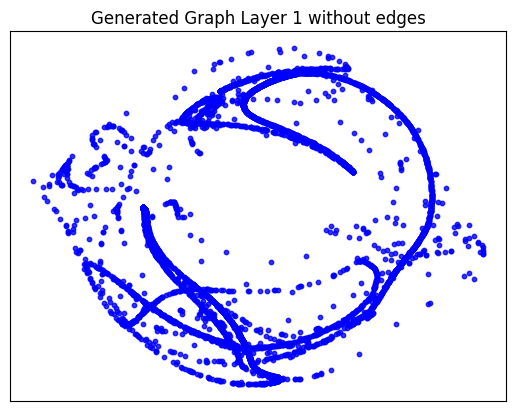

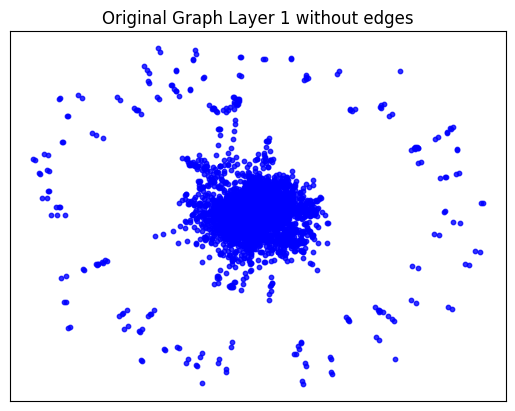

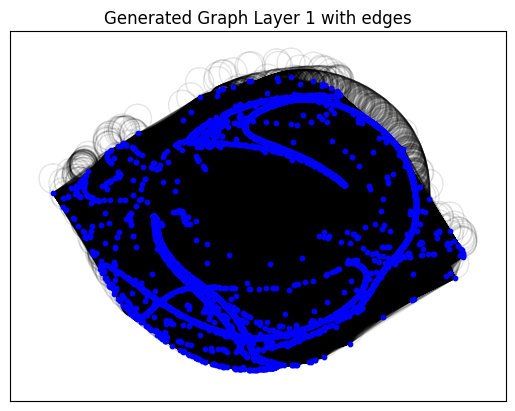

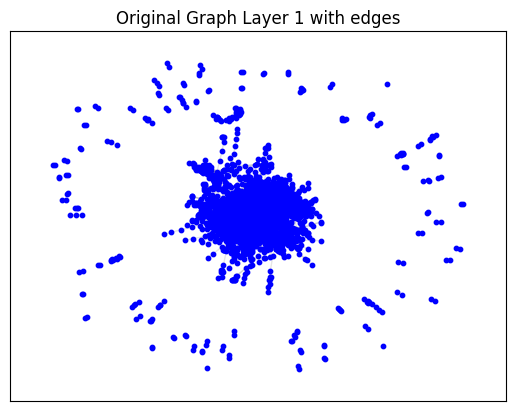

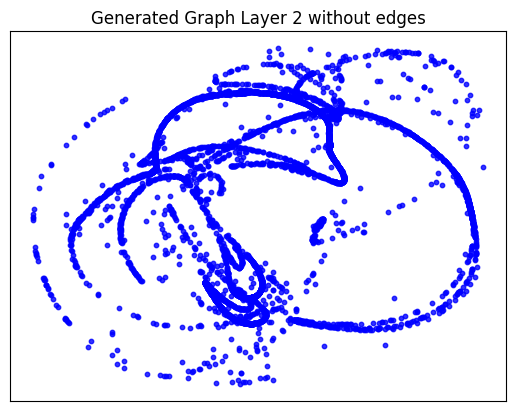

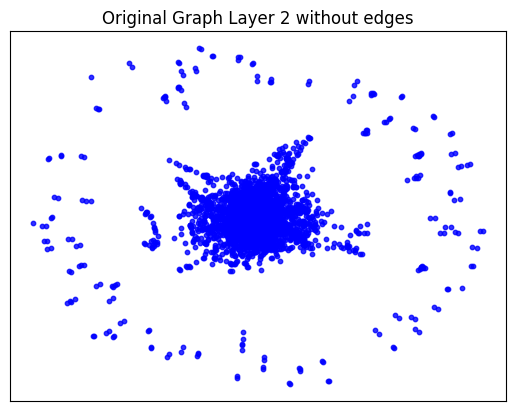

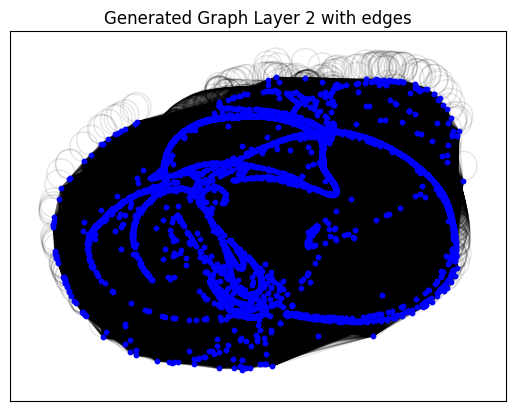

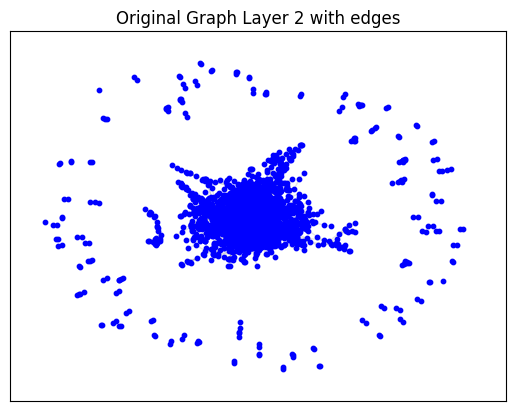

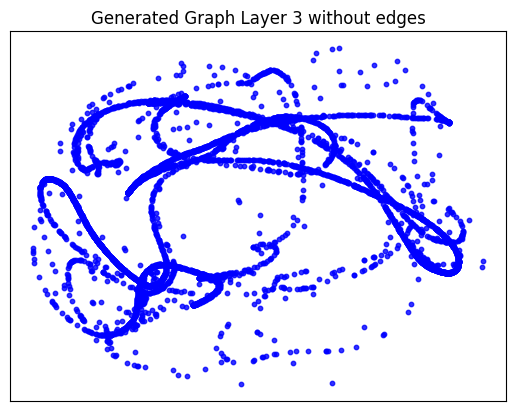

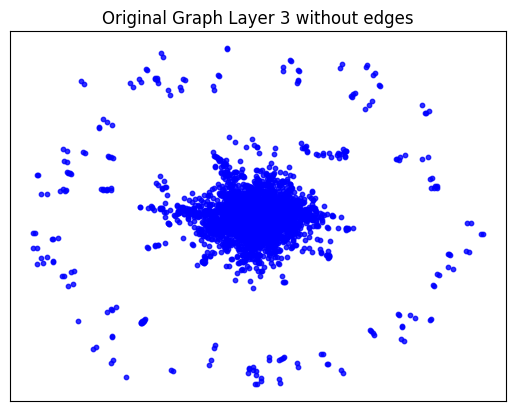

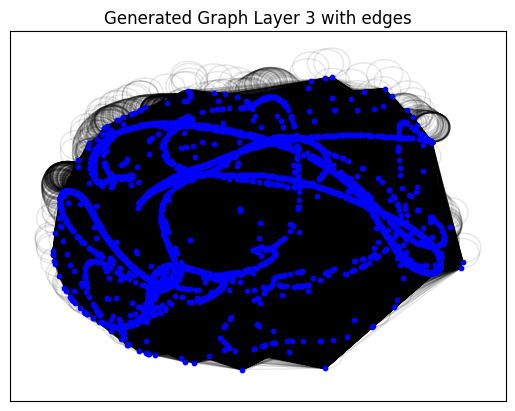

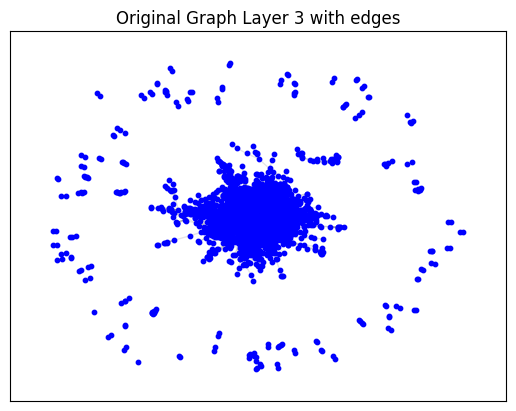

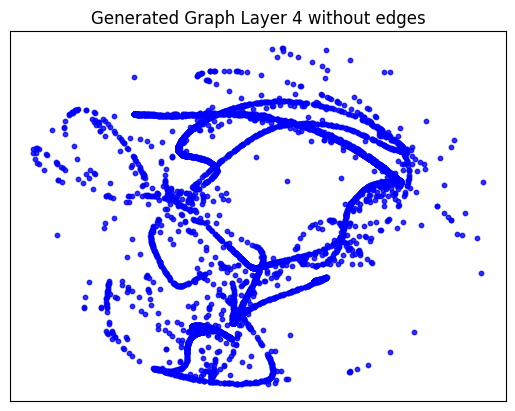

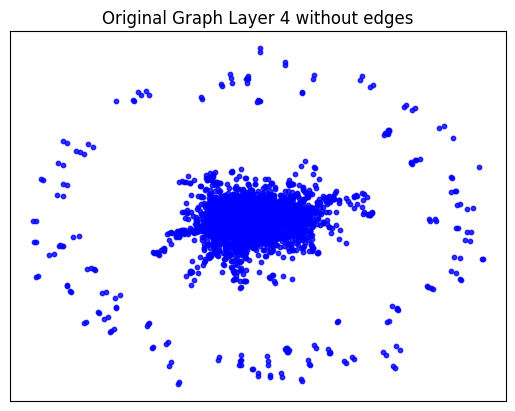

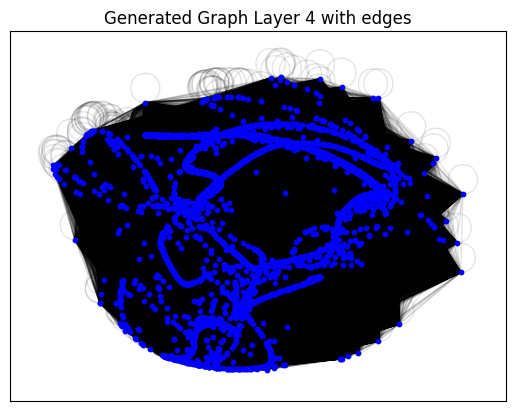

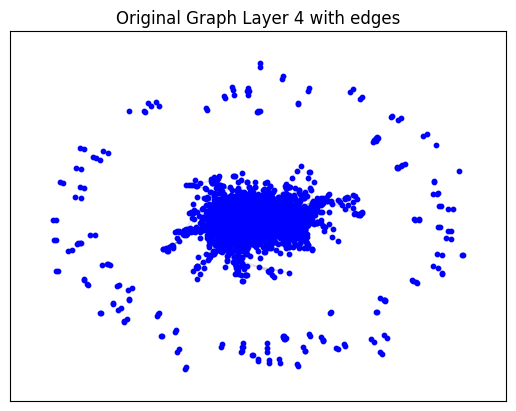

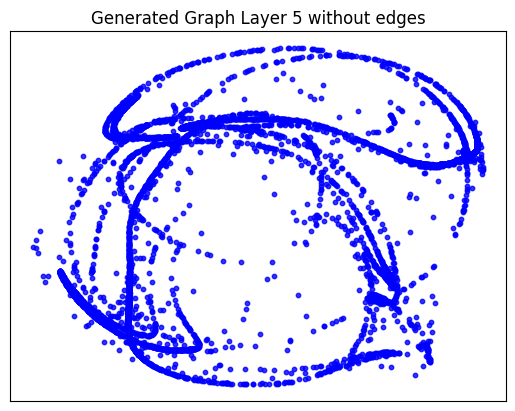

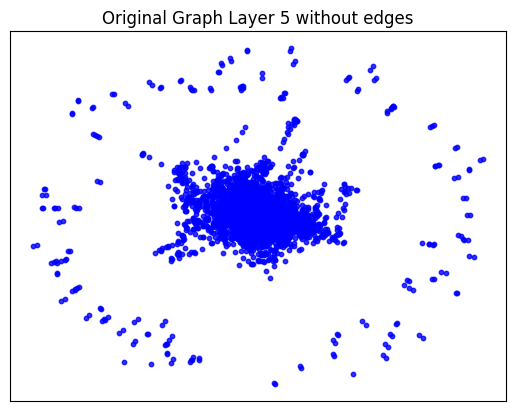

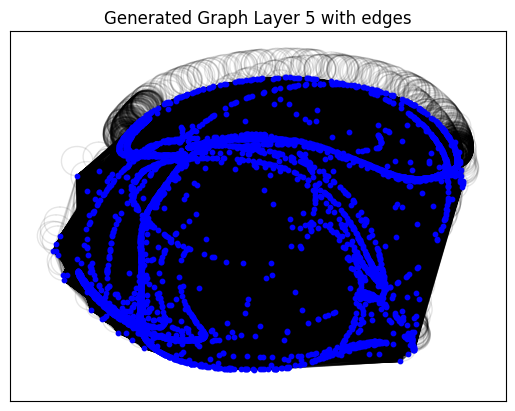

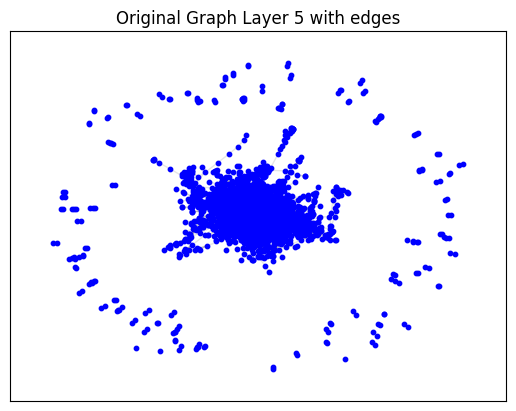

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Original graph and synthetic graph generated by Music-GAN have been saved at directory: /content/Misc-Gan_Project/output_dir_cora.
Flag learning_rate not found. Continuing...
Flag epochs not found. Continuing...
Flag hidden1 not found. Continuing...
Flag hidden2 not found. Continuing...
Flag weight_decay not found. Continuing...
Flag dropout not found. Continuing...
Flag filename not found. Continuing...
Flag model not found. Continuing...
Flag dataset not found. Continuing...
Flag features not found. Continuing...
Flag f not found. Continuing...


Instructions for updating:
targets is deprecated, use labels instead


GAE Optimization Finished!
Generating graph by GAE algorithm.
Computing metrics for graph generated by GAE
--- 0.0054433345794677734 seconds to compute statistics_degrees ---
--- 0.25495266914367676 seconds to compute statistics_LCC ---
--- 0.01042628288269043 seconds to compute statistics_wedge_count ---
--- 0.010959148406982422 seconds to compute statistics_claw_count ---
--- 0.052253007888793945 seconds to compute statistics_triangle_count ---
--- 0.006796836853027344 seconds to compute statistics_power_law_alpha ---
--- 0.006219387054443359 seconds to compute statistics_gini ---
--- 0.02026653289794922 seconds to compute statistics_edge_distribution_entropy ---
--- 0.022425174713134766 seconds to compute degree_assortativity_coefficient ---


Values less than or equal to 0 in data. Throwing out 0 or negative values


--- 0.12804174423217773 seconds to compute connected_components ---
--- 7.152557373046875e-07 seconds to compute statistics_cluster_props ---
{'d_max': 309, 'd_min': 0, 'd': 1.7943131462333826, 'LCC': 1181, 'wedge_count': 119331.0, 'claw_count': 7255686.0, 'triangle_count': 1992, 'power_law_exp': 2.5792744164264794, 'gini': 0.8290503422511879, 'rel_edge_distr_entropy': 0.7548417928902154, 'assortativity': -0.3138583832668776, 'clustering_coefficient': 0.0008236299090120493, 'n_components': 1482}
Evaluation Results:
Start computing graph degree


<ipython-input-118-586b554cc0cb>:49: RuntimeWarning: overflow encountered in exp
  e_x = np.exp((x-max)/mean)
<ipython-input-118-586b554cc0cb>:50: RuntimeWarning: invalid value encountered in divide
  return e_x / e_x.sum()
<ipython-input-118-586b554cc0cb>:5: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p * np.log(p / q))


KL divergence between original network and the network generated by Music_GAN: nan
KL divergence between original network and the network generated by Random E-R: 5.63039501557468
KL divergence between original network and the network generated by Random B-A: nan
KL divergence between original network and the network generated by GAE: 1.2679500533260433
Start computing graph coefficient


In [ ]:
import psutil
import gc
#Shahar Vachiler
args.which_stage = "testing"

tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
check_ram()
# use this to disable the gpu usage of tensorflow
#tfconfig.gpu_options.allow_growth = False
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
if args.gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)
# Clear session and garbage collection
tf.keras.backend.clear_session()
gc.collect()
# --- generating synthetic network --- #
generate_network(data_A, data_B, indices, P, A, batch_size=32)
# Clear session and garbage collection
tf.keras.backend.clear_session()
gc.collect()
# --- evaluation --- #
save_graph(R, edges)
print('Original graph and synthetic graph generated by Music-GAN have been saved at directory: {}.'.format(
    args.output_dir))
gae(args.dataset_A, args.output_dir)
print('Evaluation Results:')
evaluation()

In [ ]:
!cp /content/Misc-Gan_Project/output_dir_cora/org_network.npy /content/drive/MyDrive/Misc-Gan_Project

**Old analysis (First Semester, before GNet Integration):**

Train the 30 datasets of cora.mat after removing 30% of the edges:

In [ ]:
args.which_stage = "testing"

if args.demo:
  args.dataset_A = 'cora.mat'
  args.layer = 5
  args.starting_layer = 0
  args.kernel_number = 32
  args.iter = 7
  args.checkpoint = './checkpoint_email'
  args.output_dir = './output_dir_email'
# --- initialization --- #
tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# use this to disable the gpu usage of tensorflow
#tfconfig.gpu_options.allow_growth = False
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
if args.gpu:
  os.environ["CUDA_VISIBLE_DEVICES"] = "0"

for i in range(30):
  args = Args(i)
  #if args.which_stage == 'training':
  if not os.path.isfile('/content/drive/MyDrive/Misc-Gan_Project/data/{}'.format(args.dataset_A)):
    print('Start calling AMG algorithm to create data set!')
    os.system("matlab -nodisplay -nosplash -nodesktop -r Parsedata")
    print('Finish generating graph data set!')

  data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)
  # --- training process --- #
  for layer_idx in range(args.starting_layer, args.layer):
    model = GraphARM(data_A['l{}_1'.format(layer_idx + 1)], data_B['l{}_1'.format(layer_idx + 1)])
    model.train(layer_idx)
        # netgan = np.load('{}/netgan_network.npy'.format(args.output_dir))
        # a = compute_graph_statistics(netgan[1])
        # print(a)
        # with open('./{}/netgan_network_statistics.pickle'.format(args.checkpoint), 'wb') as handle:
        #     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #else:
    #    print('stage should be either training or testing.')

In [ ]:
!cp -r /content/Misc-Gan_Project /content/drive/MyDrive/Miscgan-Training

Test the model:

In [ ]:
for i in range(30):
  args = Args(i)
  tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  tfconfig.gpu_options.allow_growth = True
  tf.compat.v1.reset_default_graph()
  tf.compat.v1.disable_eager_execution()
  #elif args.which_stage == 'testing':
  data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)
  # --- generating synthetic network --- #
  generate_network(data_A, data_B, indices, P, A)
  # --- evaluation --- #
  save_graph(R, edges)
  print('Original graph and synthetic graph generated by Music-GAN have been saved at directory: {}.'.format(
      args.output_dir))
  gae(args.dataset_A, args.output_dir)
  print('Evaluation Results:')
  evaluation()

In [ ]:
!cp -r /content/Misc-Gan_Project /content/drive/MyDrive/Miscgan-TrainingAndTesting

In [ ]:
args.which_stage = "testing"

if args.demo:
  args.dataset_A = 'cora.mat'
  args.layer = 5
  args.starting_layer = 0
  args.kernel_number = 32
  args.iter = 7
  args.checkpoint = './checkpoint_email'
  args.output_dir = './output_dir_email'
# --- initialization --- #
tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# use this to disable the gpu usage of tensorflow
#tfconfig.gpu_options.allow_growth = False
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
if args.gpu:
  os.environ["CUDA_VISIBLE_DEVICES"] = "0"

args = Args(40)
#if args.which_stage == 'training':
if not os.path.isfile('/content/drive/MyDrive/Misc-Gan_Project/data/{}'.format(args.dataset_A)):
  print('Start calling AMG algorithm to create data set!')
  os.system("matlab -nodisplay -nosplash -nodesktop -r Parsedata")
  print('Finish generating graph data set!')

data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)
# --- training process --- #
for layer_idx in range(args.starting_layer, args.layer):
  model = GraphARM(data_A['l{}_1'.format(layer_idx + 1)], data_B['l{}_1'.format(layer_idx + 1)])
  model.train(layer_idx)

In [ ]:
args = Args(40)
tfconfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
#elif args.which_stage == 'testing':
data_A, data_B, indices, P, A, edges, R = preproc_data(tf.compat.v1.Session(config=tfconfig), net, gnet_args)
# --- generating synthetic network --- #
generate_network(data_A, data_B, indices, P, A)
# --- evaluation --- #
save_graph(R, edges)
print('Original graph and synthetic graph generated by Music-GAN have been saved at directory: {}.'.format(
    args.output_dir))
gae(args.dataset_A, args.output_dir)
print('Evaluation Results:')
evaluation()

In [ ]:
!cp /content/Misc-Gan_Project/output_dir_cora_40/org_network.npy /content/drive/MyDrive

In [ ]:
orig = np.load('/content/drive/MyDrive/Misc-Gan_Project/org_network.npy')
file_names_array = [{'truncated': '/content/drive/MyDrive/Miscgan-TrainingAndTesting/output_dir_cora_{}/org_network.npy'.format(i),'generated': '/content/drive/MyDrive/Miscgan-TrainingAndTesting/output_dir_cora_{}/cora_output_network_{}.npy'.format(i,i)} for i in range(30)]

# Step 1: Get indices of cells in `orig` that are 1
one_indices = np.where(orig == 1)
i = 0

with open('/content/drive/MyDrive/Misc-Gan_Project/recovered_edges_output.txt', 'w') as f:
  for file_names_dict in file_names_array:
      generated = np.load(file_names_dict['generated'])
      truncated = np.load(file_names_dict['truncated'])

      # Step 2: Use these indices to index into the second matrix and find where these are 0
      dropped_edges_1 = np.where(truncated[one_indices] == 0)

      # Convert the filtered indices to the original indices format
      dropped_edges = (one_indices[0][dropped_edges_1], one_indices[1][dropped_edges_1])

      recovered_edges_1 = np.where(generated[dropped_edges] == 1)
      num_recovered_edges = recovered_edges_1[0].size

      print(f'In iteration {i}, the number of edges that are recovered: {num_recovered_edges}')
      f.write(f'{num_recovered_edges}\n')

      i = i + 1
      # recovered_edges = (dropped_edges[0][recovered_edges_1], dropped_edges[1][recovered_edges_1])

Calculate the Jaccard Similarity matrices (generated graphs)

In [ ]:
import numpy as np
import os

# Load the matrices from the .npy files into a list
matrices = []
for i in range(0, 30):
    matrix = np.load(f'/content/drive/MyDrive/Miscgan-TrainingAndTesting/output_dir_cora_{i}/cora_output_network_{i}.npy')
    matrices.append(matrix)

# Define the functions for converting adjacency matrices to edge sets and calculating Jaccard similarity
def adjacency_matrix_to_edge_set(matrix):
    edges = set()
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 1:
                edges.add((i, j))
    return edges

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Convert each adjacency matrix to a set of edges
edge_sets = [adjacency_matrix_to_edge_set(matrix) for matrix in matrices]

# Calculate the similarity matrix
similarity_matrix = np.zeros((30, 30))
for i in range(30):
    for j in range(30):
        similarity_matrix[i, j] = jaccard_similarity(edge_sets[i], edge_sets[j])

# Print the similarity matrix
print(similarity_matrix)


In [ ]:
normalized_similarity_matrix = np.clip(similarity_matrix, 0, 1)

# Print the similarity matrix with formatting for readability
np.set_printoptions(precision=3, suppress=True)
print(normalized_similarity_matrix)
with open('/content/drive/MyDrive/Misc-Gan_Project/jaccard_similarity_matrix_1.txt', 'w') as f:
  f.write(f'{normalized_similarity_matrix}')

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 13))
cax = ax.matshow(normalized_similarity_matrix, cmap='viridis')

# Add colorbar
fig.colorbar(cax)

# Set up threshold to only display text above a certain similarity value to avoid clutter
threshold = normalized_similarity_matrix.max() / 2.

# Set font size
font_size = 8  # Adjust as needed

# Add values inside the plot
for i in range(normalized_similarity_matrix.shape[0]):
    for j in range(normalized_similarity_matrix.shape[1]):
        if normalized_similarity_matrix[i, j] > threshold:  # Only add text for significant similarities
            color = "white" if normalized_similarity_matrix[i, j] > threshold else "black"
            ax.text(j, i, f'{normalized_similarity_matrix[i, j]:.2f}',
                    ha='center', va='center', color=color, fontsize=font_size)

# Set labels
ax.set_title('Similarity Matrix', pad=20)
ax.set_xlabel('Matrix Index')
ax.set_ylabel('Matrix Index')

# Show plot
plt.show()

In [ ]:
import numpy as np
import os

orig = np.load('/content/drive/MyDrive/Misc-Gan_Project/org_network.npy')

# Load the matrices from the .npy files into a list
generated_matrices = []
for i in range(0, 30):
    matrix = np.load(f'/content/drive/MyDrive/Miscgan-TrainingAndTesting/output_dir_cora_{i}/cora_output_network_{i}.npy')
    generated_matrices.append(matrix)

orig_removed_edges = []
for i in range(0, 30):
    matrix = np.load(f'/content/drive/MyDrive/Miscgan-TrainingAndTesting/output_dir_cora_{i}/org_network.npy')
    orig_removed_edges.append(matrix)

# Define the functions for converting adjacency matrices to edge sets and calculating Jaccard similarity
def adjacency_matrix_to_edge_set(matrix):
    edges = set()
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 1:
                edges.add((i, j))
    return edges

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Convert each adjacency matrix to a set of edges
generated_edge_sets = [adjacency_matrix_to_edge_set(matrix) for matrix in generated_matrices]
orig_removed_edge_sets = [adjacency_matrix_to_edge_set(matrix) for matrix in orig_removed_edges]
orig_edge_sets = adjacency_matrix_to_edge_set(orig)

In [ ]:
similarity_matrix_2 = np.zeros((30, 2))
for i in range(30):
  similarity_matrix_2[i, 0] = jaccard_similarity(orig_edge_sets, generated_edge_sets[i])
  similarity_matrix_2[i, 1] = jaccard_similarity(orig_removed_edge_sets[i], generated_edge_sets[i])

# Print the similarity matrix
print(similarity_matrix_2)
with open('/content/drive/MyDrive/Misc-Gan_Project/jaccard_similarity_matrix_2.txt', 'w') as f:
  f.write(f'{similarity_matrix_2}')